<a href="https://colab.research.google.com/github/berenguler/Multi-class-enzyme-prediction-PBL/blob/main/Final_Version_PBL_Multiclass_Classification_with_CNNs_%26_FNNs_(Enzyme_Prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/PBL/Problem_Based_Learning-main/Code

/content/drive/MyDrive/PBL/Problem_Based_Learning-main/Code


### Imports

In [ ]:
#!git clone https://github.com/Bjarten/early-stopping-pytorch.git

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 11.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import torch.optim as optim

from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from pathlib import Path
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import MulticlassF1Score
import itertools
from sklearn.metrics import accuracy_score, matthews_corrcoef
import matplotlib.pyplot as plt
import random
import Custom_Dataset as CD
import ConfMatrixBuilder as CMB
import json
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib as mpl


data_path = Path("../dataset")
train_seq = data_path / "train_set.fasta"


seed = 42 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
def plot_loss(train_losses,valid_losses,train_accs,valid_accs, fold, model_type):
    stat_dataframe = pd.DataFrame([])
    stat_dataframe["training_loss"] = train_losses
    stat_dataframe["validation_loss"] = valid_losses
    stat_dataframe["training_acc"] = train_accs
    stat_dataframe["validation_acc"] = valid_accs

    axes = [1,2]
    plt.figure()
    axes[0] = stat_dataframe[["training_loss", "validation_loss"]].plot(figsize=(12,7.5), title='Average Loss', fontsize=16)
    axes[0].title.set_size(40)
    axes[0].set_xlabel('Epoch',fontdict={'fontsize':30})
    axes[0].set_ylabel('Loss',fontdict={'fontsize':30})
    plt.legend(fontsize = 20)
    plt.savefig(f"{model_type}-loss-curve-fold{fold}.png")
    plt.figure()
    axes[1] = stat_dataframe[["training_acc", "validation_acc"]].plot(figsize=(12,7.5), title='Average Accuracy', fontsize=16)
    axes[1].title.set_size(30)
    axes[1].set_xlabel('Epoch',fontdict={'fontsize':25})
    axes[1].set_ylabel('Accuracy',fontdict={'fontsize':25})
    plt.legend(fontsize = 20)
    plt.savefig(f"{model_type}-accuracy-curve-fold{fold}.png")


### Early Stopping

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


### Build Dataset

Reading data and preparing OHE sequences for training

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

class MainclassDataset(Dataset):
    """Mainclass Dataset for Enzyme Sequences"""
    
    def __init__(self, data = pd.read_csv("Seq_EMainclass.csv"), max_seqlen = 1000):
        
        def amino_acid_mapping(sequence:str):
            trans = str.maketrans("BUZJO", "XXXXX")
            sequence = sequence.translate(trans)
            map_aa = {
                'A': 0,
                'C': 1,
                'D': 2,
                'E': 3,
                'F': 4,
                'G': 5,
                'H': 6,
                'I': 7,
                'K': 8,
                'L': 9,
                'M': 10,
                'N': 11,
                'P': 12,
                'Q': 13,
                'R': 14,
                'S': 15,
                'T': 16,
                'V': 17,
                'W': 18,
                'Y': 19,
                'X': 20
            }
            if(len(sequence) <= max_seqlen):
                result = torch.zeros((max_seqlen, 21))
                for num_id, residue in enumerate(sequence):
                    result[num_id][map_aa[residue]] = 1
                return result
            return None
        
        
        self.data = data
        train_ohe = []
        for seq in self.data["Sequence"]:
            aa = amino_acid_mapping(seq)
            train_ohe.append(aa)
        self.data["One_Hot_Encoded_Sequences"] = train_ohe
        
        for row in self.data.index:
            if self.data.loc[row, 'One_Hot_Encoded_Sequences'] == None:
                self.data.drop(row, inplace = True)
        
    def __len__(self):
        return len(self.data["Enzyme_Mainclass"])

    def __getitem__(self, index):
        #print(index)
        #print(self.data.iloc[index, 1])
        return torch.tensor(self.data.iloc[index, 2]), torch.tensor(self.data.iloc[index, 1])
      
    def get_ohe(self):
        return self.data["One_Hot_Encoded_Sequences"]

Reading embedding vector data and preparing it for training



In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

class MainclassEmbeddingPRDataset(Dataset):
    """Mainclass Dataset for Enzyme Sequences"""
    
    def __init__(self, data_file, uid_to_ec_file, max_seqlen=1000):
        
        raw_data = np.load(data_file, allow_pickle=True)
        uid_to_ec = pd.read_csv(uid_to_ec_file, sep='\t')

        self.data = pd.DataFrame([])
        self.data['embs'] = raw_data['embs']
        self.data['labels'] = uid_to_ec[uid_to_ec.Entry.isin(raw_data['uids'])]["EC number"].str[0]
        del raw_data
        self.data = self.data[self.data['labels'].notna()].reset_index(drop=True)
        self.data['labels'] = self.data.labels.astype(int).values    

        #self.data.loc[:, 'embs'] = self.data.embs.apply(lambda row: self.pad_sequences(row, max_seqlen))
        for i, item in enumerate(self.data['embs']):
            self.data['embs'][i] = self.pad_sequences(item, max_seqlen)
        
    def __len__(self):
        return len(self.data["labels"])

    def __getitem__(self, index):
        return self.data["embs"][index], self.data["labels"][index]
    
    def pad_sequences(self, item, max_seqlen):
        shape = item.shape
        if(shape[0] <= max_seqlen):
            result = torch.zeros((max_seqlen, 1024))
            result[:shape[0],:shape[1]] = torch.tensor(item)
        return result

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

class MainclassEmbeddingPPDataset(Dataset):
    """Mainclass Dataset for Enzyme Sequences"""
    
    def __init__(self, data_file, uid_to_ec_file, max_seqlen=1000):
        
        raw_data = np.load(data_file, allow_pickle=True)
        uid_to_ec = pd.read_csv(uid_to_ec_file, sep='\t')

        self.data = pd.DataFrame([])
        self.data['embs'] = pd.Series(map(lambda x: x, raw_data['embs']))
        self.data['labels'] = uid_to_ec[uid_to_ec.Entry.isin(raw_data['uids'])]["EC number"].str[0]
        del raw_data
        self.data = self.data[self.data['labels'].notna()].reset_index(drop=True)
        self.data['labels'] = self.data.labels.astype(int).values    


    def __len__(self):
        return len(self.data["labels"])

    def __getitem__(self, index):
        return self.data["embs"][index], self.data["labels"][index]

# Building the model

In [ ]:
class FirstNeuralNetwork(nn.Module):
    def __init__(self):
        super(FirstNeuralNetwork, self).__init__()
        self.softmax = nn.Softmax()
        self.conv1 = nn.Conv1d(1000, 6, 5)
        #self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv1d(6, 16, 5)
        
        self.fc1 = nn.Linear(208, 120) # input size could be found by reading the error messages.
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        #x = self.flatten(x)
        #x = self.cnn(x)
        #probability_dist = self.softmax(x)
        #return probability_dist
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.softmax(x)
        return x


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
class SecondNeuralNetwork(nn.Module):
    def __init__(self):
        super(SecondNeuralNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Conv1d(21, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=4),
            nn.Conv1d(16, 4, 1),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=4),
            nn.Flatten(),
            nn.Dropout(0.75),
            nn.Linear(248, 60),
            nn.ReLU(),
            nn.Linear(60, 15),
            nn.ReLU(),
            nn.Linear(15, 7),
            nn.Softmax()
        )

    def forward(self, x):
        return self.net(x)

    def print(self, x, a):
        if a:
            for layer in self.net:
                x = layer(x)
                print(f"{layer.__class__.__name__}:  \t", x.size())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [ ]:
class ThirdNeuralNetwork(nn.Module):
    def __init__(self):
        super(ThirdNeuralNetwork, self).__init__()
        out_channels = 8

        self.net = nn.Sequential(
            nn.Conv1d(21, out_channels, 8),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(993 * out_channels, 7),
            nn.Softmax()
        )

    def forward(self, x):
        return self.net(x)

    def print(self, x, a):
        if a:
            for layer in self.net:
                x = layer(x)
                print(f"{layer.__class__.__name__}:  \t", x.size())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [ ]:
class ForthNeuralNetwork(nn.Module):
    def __init__(self):
        super(ForthNeuralNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Dropout(0.75),
            nn.Linear(64, 7),
            nn.Softmax()
        )

    def forward(self, x):
        return self.net(x)

    def print(self, x, a):
        if a:
            for layer in self.net:
                x = layer(x)
                print(f"{layer.__class__.__name__}:  \t", x.size())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


# Code Example for creating model architecture

Analyzing inside the forward function: 

In [ ]:
for inputs, labels in trainloader:
    inputs = inputs#.permute(0,2,1)#.unsqueeze(1)
    break
inputs.shape

torch.Size([32, 1024])

In [ ]:
labels

tensor([4, 1, 2, 2, 4, 2, 2, 2, 4, 5, 4, 2, 3, 4, 2, 3, 3, 6, 6, 6, 2, 2, 2, 4,
        4, 2, 4, 3, 1, 3, 5, 3])

In [ ]:
index = 0
self = ForthNeuralNetwork()#.to(device)
x = inputs[index].unsqueeze(0).float()#.to(device)
print("Input :", x.shape)
self.print(x, True)
self(x).shape

Input : torch.Size([1, 1024])
Linear:  	 torch.Size([1, 64])
ReLU:  	 torch.Size([1, 64])
Linear:  	 torch.Size([1, 7])
Softmax:  	 torch.Size([1, 7])


torch.Size([1, 7])

In [ ]:
"""
x = torch.randn(1, 21, 1000, requires_grad=False).to(device)
ex_model = SecondNeuralNetwork().to(device)
y = ex_model(x)

dot = torchviz.make_dot(y.mean(), dict(ex_model.named_parameters()))
dot.format = "png"
dot.render(directory="/content/drive/MyDrive")
#"""

# Model Graph

In [ ]:
!pip install hiddenlayer 

In [ ]:
!pip3 install graphviz

In [ ]:
!pip install pytorch==0.4.0

In [ ]:
import hiddenlayer as hl

In [ ]:
model = FirstNeuralNetwork()
input = torch.zeros([1, 1000, 21])
hl.build_graph(model, input)

In [ ]:
model = SecondNeuralNetwork()
input = torch.zeros([1, 21, 1000])
hl.build_graph(model, input)

In [ ]:
import torchviz

x = torch.randn(1, 1000, 21).to(device)
ex_model = FirstNeuralNetwork().to(device)
y = ex_model(x)

dot = torchviz.make_dot(y.mean(), dict(ex_model.named_parameters()))
dot.format = "png"
dot.render(directory="/content/drive/MyDrive")

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter('/content/logsdir')

In [ ]:
!tensorboard --logdir = content/logsdir

# Train the model

## OHE

In [ ]:
data = MainclassDataset()

batch_size = 32
k = 10
patience = 7 
splits = KFold(n_splits=k, shuffle=True, random_state=seed)

Streaming output truncated to the last 5000 lines.
Train:
Epoch [75/100], Step [27], Loss: 1.4434, Avg.Accuracy: 0.974

Validation:
Epoch [75/100], Step [3], Loss: 1.8376, Avg.Accuracy: 0.305

Train:
Epoch [76/100], Step [27], Loss: 1.4401, Avg.Accuracy: 0.974

Validation:
Epoch [76/100], Step [3], Loss: 1.8379, Avg.Accuracy: 0.295

Train:
Epoch [77/100], Step [27], Loss: 1.4369, Avg.Accuracy: 0.974

Validation:
Epoch [77/100], Step [3], Loss: 1.8382, Avg.Accuracy: 0.274

Train:
Epoch [78/100], Step [27], Loss: 1.4338, Avg.Accuracy: 0.974

Validation:
Epoch [78/100], Step [3], Loss: 1.8387, Avg.Accuracy: 0.263

Train:
Epoch [79/100], Step [27], Loss: 1.4308, Avg.Accuracy: 0.974

Validation:
Epoch [79/100], Step [3], Loss: 1.8391, Avg.Accuracy: 0.274

Train:
Epoch [80/100], Step [27], Loss: 1.4278, Avg.Accuracy: 0.975

Validation:
Epoch [80/100], Step [3], Loss: 1.8394, Avg.Accuracy: 0.305

Train:
Epoch [81/100], Step [27], Loss: 1.4249, Avg.Accuracy: 0.975

Validation:
Epoch [81/100], 

<Figure size 432x288 with 0 Axes>

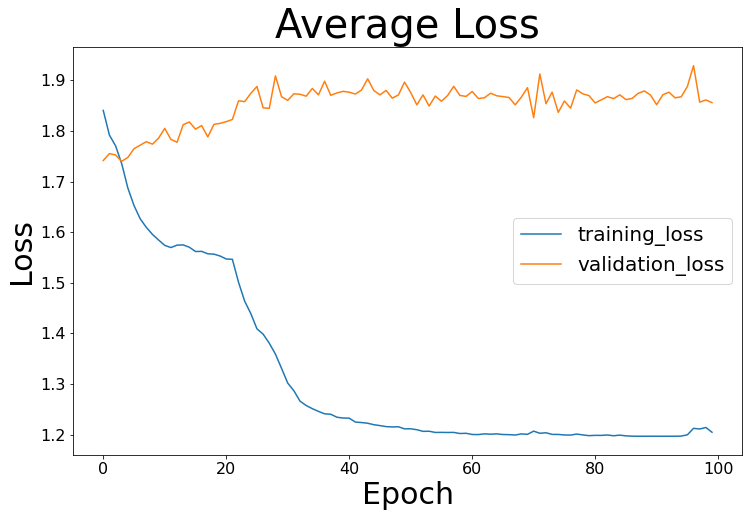

<Figure size 432x288 with 0 Axes>

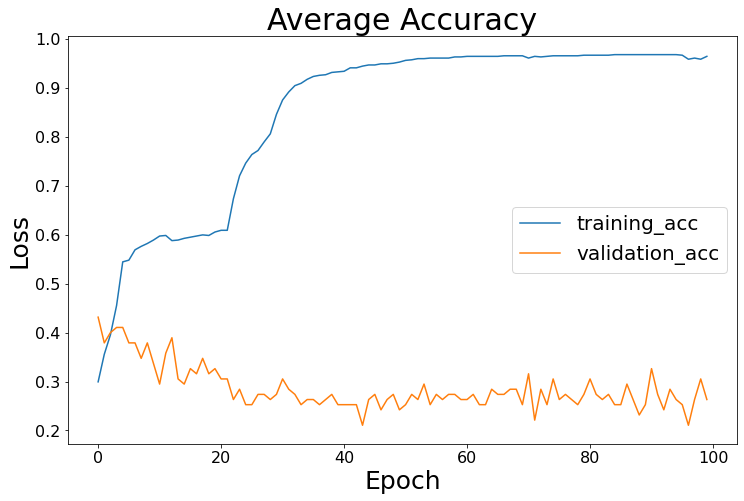

<Figure size 432x288 with 0 Axes>

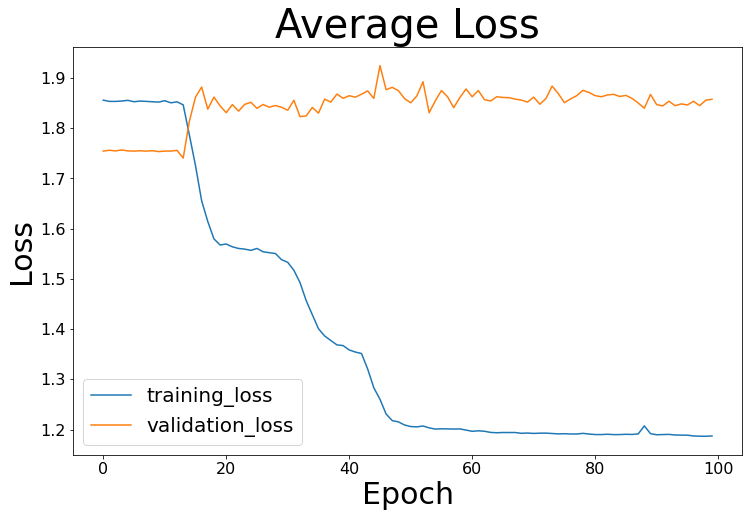

<Figure size 432x288 with 0 Axes>

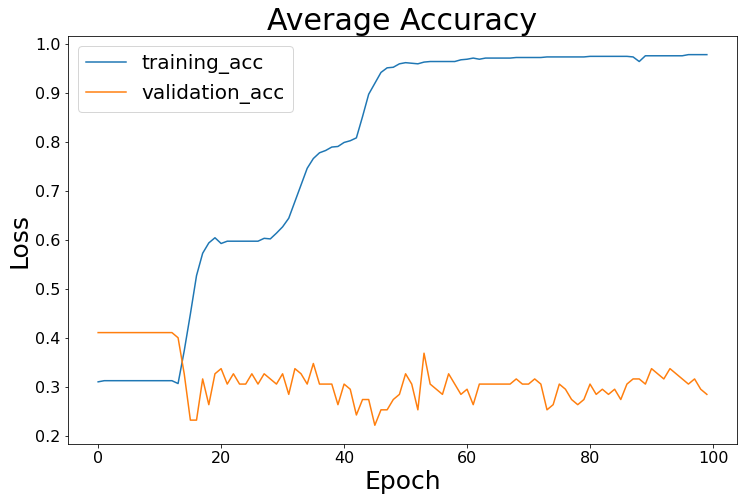

<Figure size 432x288 with 0 Axes>

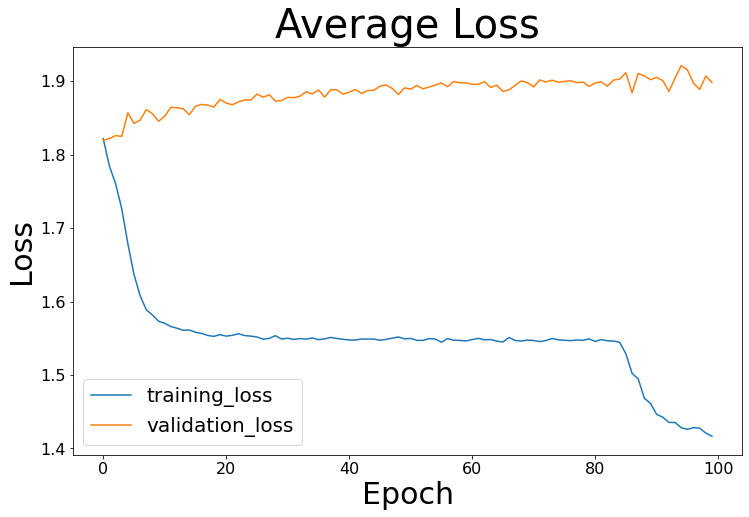

<Figure size 432x288 with 0 Axes>

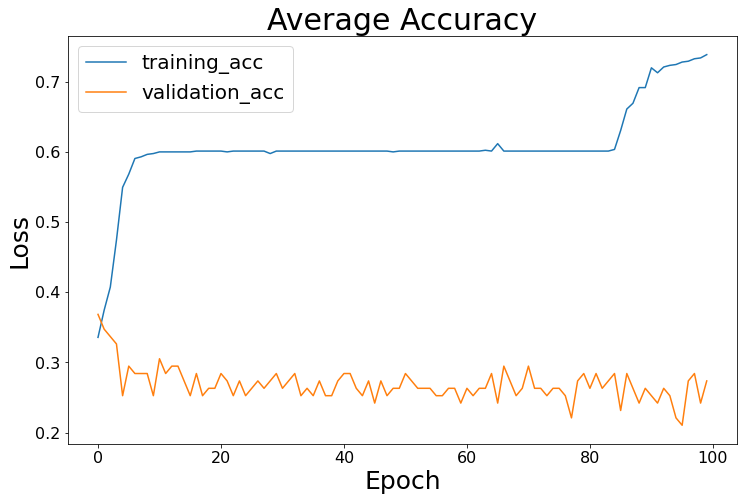

<Figure size 432x288 with 0 Axes>

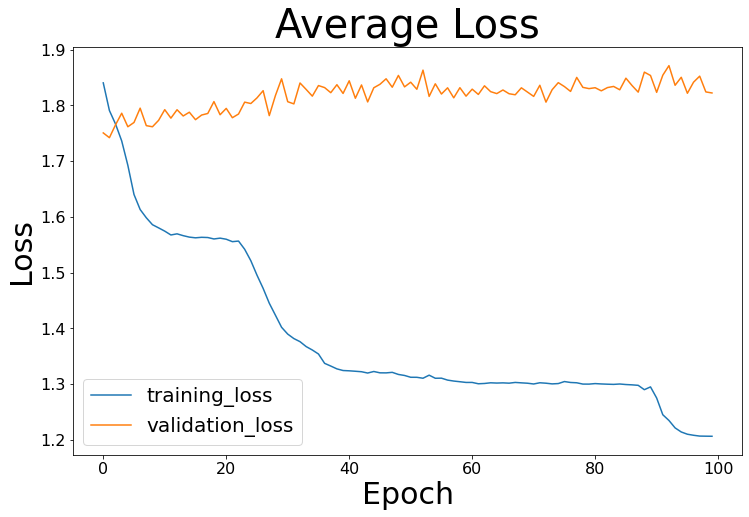

<Figure size 432x288 with 0 Axes>

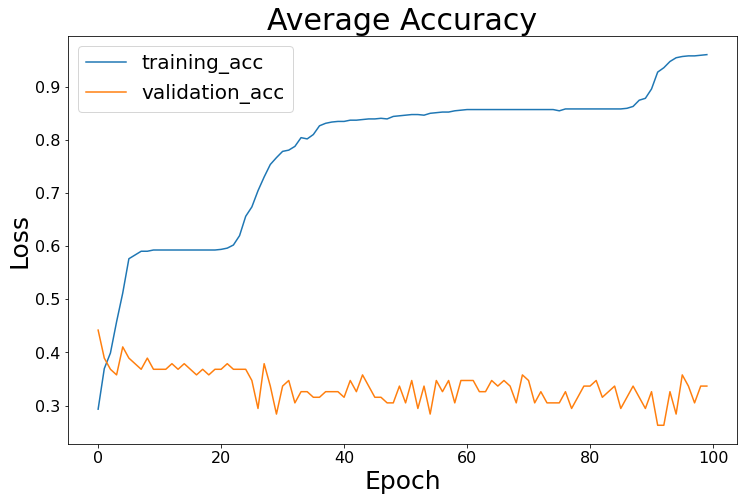

<Figure size 432x288 with 0 Axes>

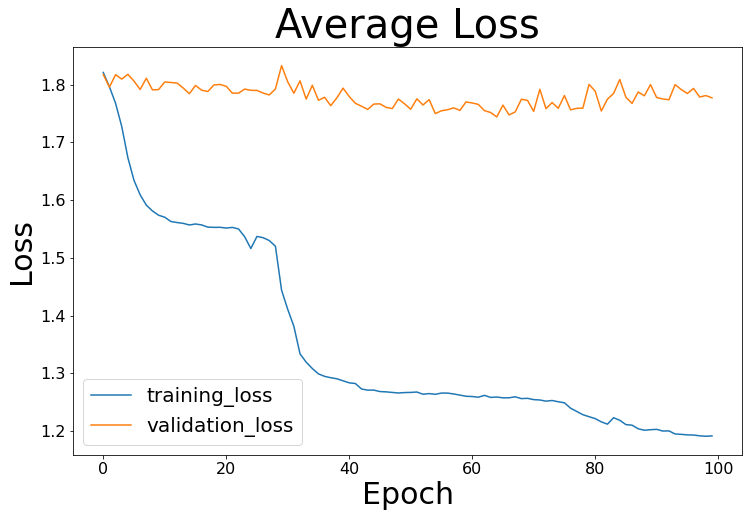

<Figure size 432x288 with 0 Axes>

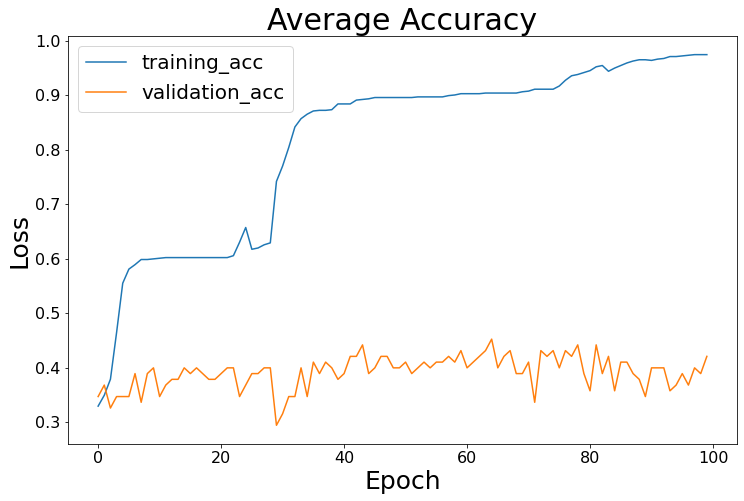

<Figure size 432x288 with 0 Axes>

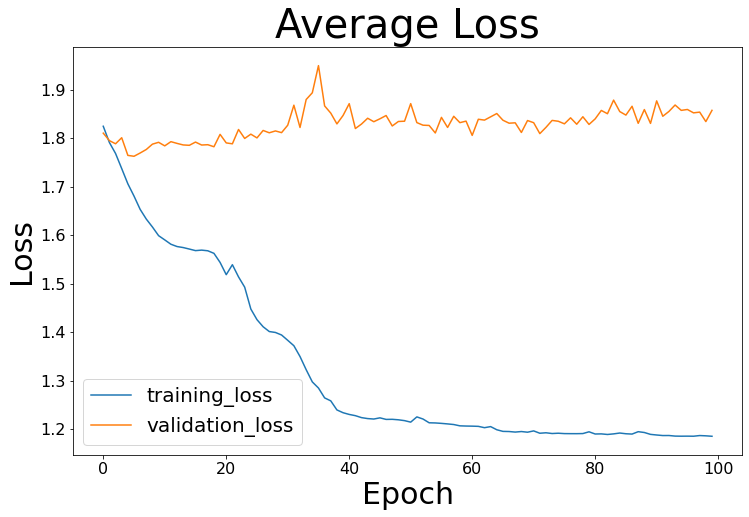

<Figure size 432x288 with 0 Axes>

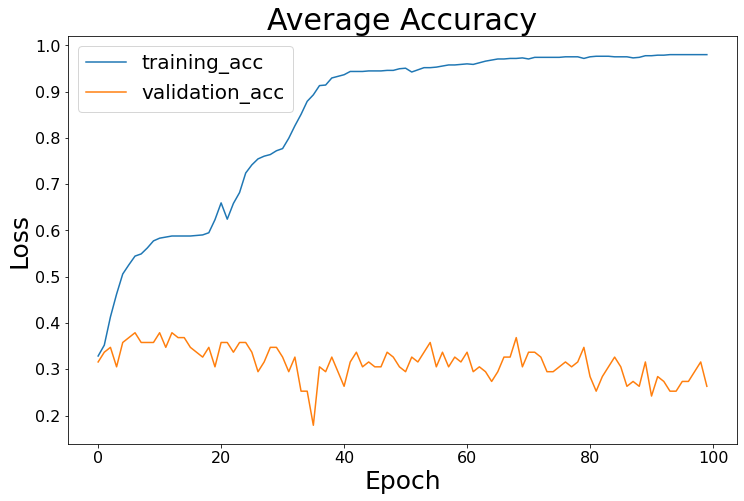

<Figure size 432x288 with 0 Axes>

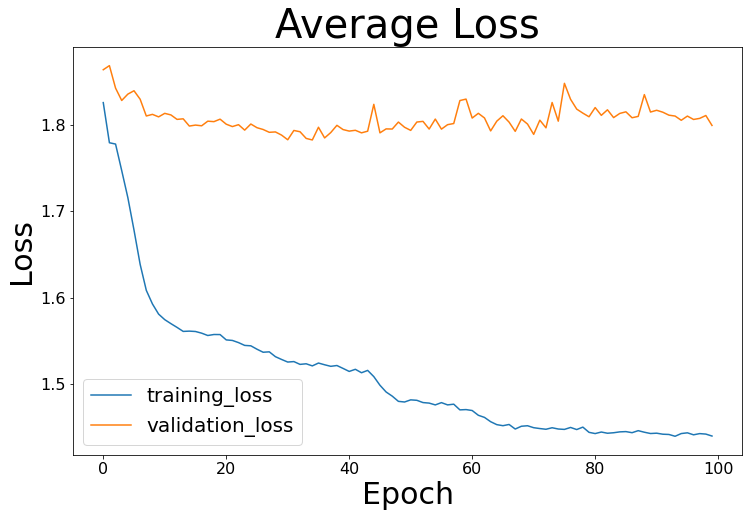

<Figure size 432x288 with 0 Axes>

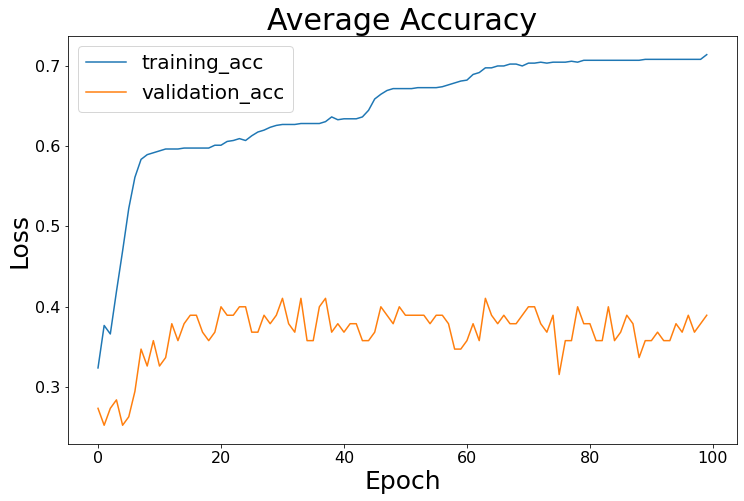

<Figure size 432x288 with 0 Axes>

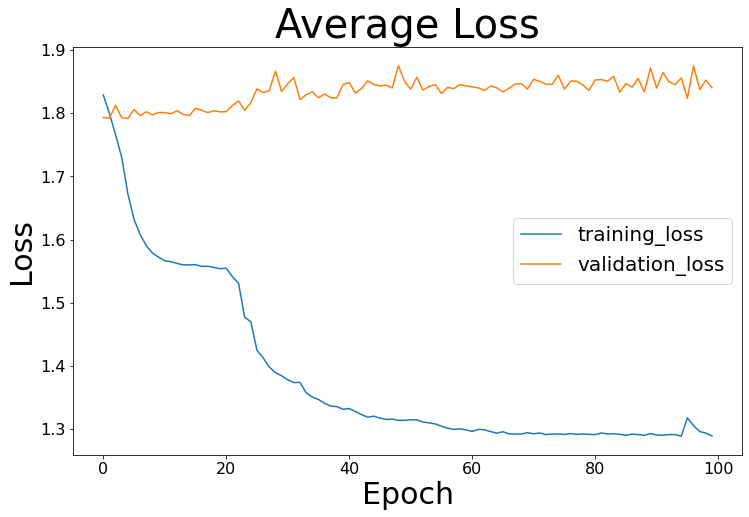

<Figure size 432x288 with 0 Axes>

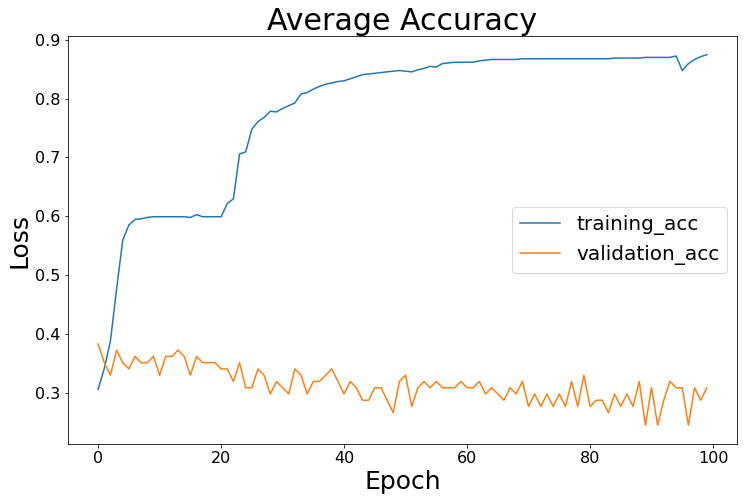

<Figure size 432x288 with 0 Axes>

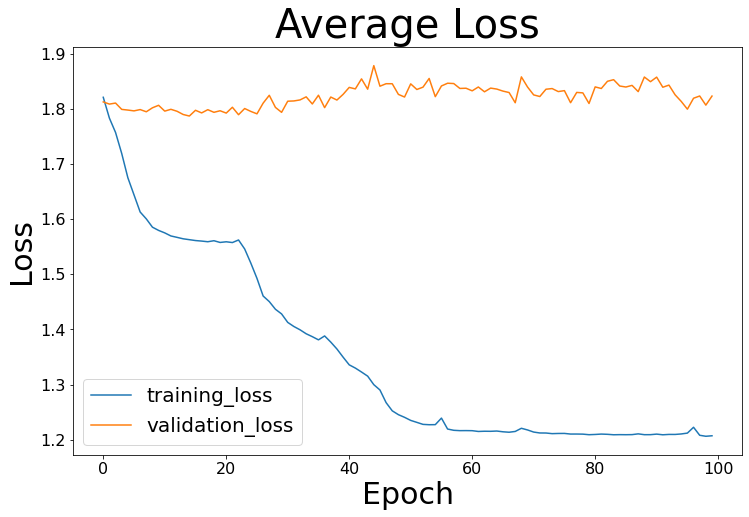

<Figure size 432x288 with 0 Axes>

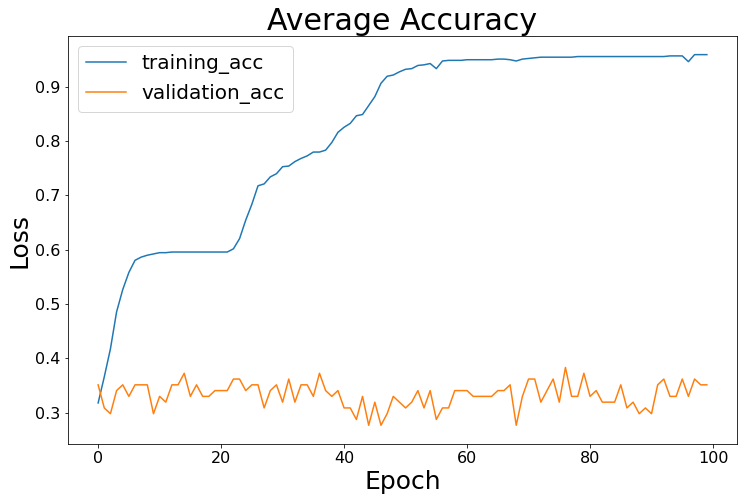

<Figure size 432x288 with 0 Axes>

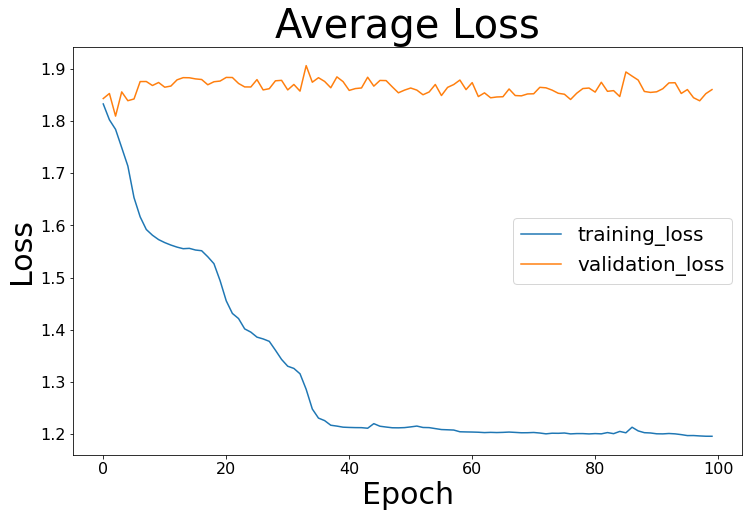

<Figure size 432x288 with 0 Axes>

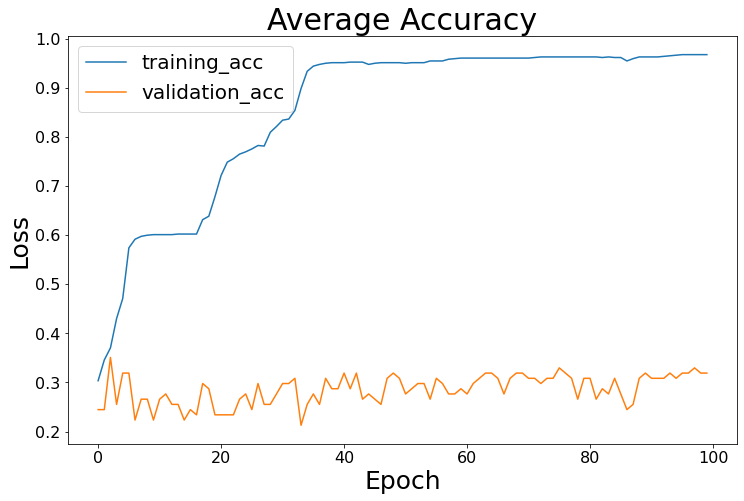

In [ ]:
MODEL_TYPE = "ohe-ns"
early_stop = False


confusion_matrix_list = []
losses_train = []
losses_valid = []
matthews = []
accuracies = []
accs_train = []
accs_valid = []
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(data)))):

    print(f'\n\n{20*"*"} Fold {fold + 1} {20*"*"}')

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    trainloader = DataLoader(data, batch_size=batch_size, sampler=train_sampler, num_workers=4)
    validloader = DataLoader(data, batch_size=batch_size, sampler=val_sampler, num_workers=4)

    model = ThirdNeuralNetwork().to(device)
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Adam can be used as well #the step size can be changed and the loss value can be evaluated 
    optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4) # in order to prevent over-fitting
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    epochs = 100
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    confusion_matrix = torch.zeros(2, 3)
    confmat = ConfusionMatrix(task="multiclass", num_classes=7).to(device)
    f1_scores = MulticlassF1Score(num_classes=7).to(device)
    labels_list = []
    predictions_list = []
    for epoch in range(epochs):
        
        train_loss = 0.0
        model.train()
        i = 0
        batch_group = len(trainloader)
        train_total = 0
        train_correct = 0

        valid_total = 0
        valid_correct = 0
        valid_acc = []
        labels_list = []
        predictions_list = []

        print(f"\nTrain:")
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.permute(0,2,1).to(device) #pytorch: batch, channel, height width --> we have 1D
            labels = (labels-1).to(device)
            labels_list.extend(labels)
            batch_len = labels.shape[0]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            #break
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predictions = torch.max(outputs.data, 1) #accuracy  
            predictions_list.extend(predictions)
            # Get training statistics.
            # print statistics
            train_loss += loss.item()
            if i % batch_group == batch_group-1: 
                #print(f"Train {i},({epoch}/{epochs}):\t{train_loss/i:.4f}") 
                #train_loss = 0.0
                i += 0
            i = i + 1
        
        train_losses.append(train_loss/batch_group)
        labels_list = [x.cpu() for x in labels_list]
        predictions_list = [x.cpu() for x in predictions_list]
        acc =  accuracy_score(labels_list, predictions_list)
        train_accs.append(acc)
        stats = 'Epoch [{}/{}], Step [{}], Loss: {:.4f}, Avg.Accuracy: {:.3f}'.format(epoch, epochs, i, np.mean(train_losses), acc)
        print(stats)

        #"""
        batch_group = len(validloader)
        valid_loss = 0.0
        labels_list = []
        predictions_list = []
        i = 0
        print(f"\nValidation:")
        model.eval()     # Optional when not using Model Specific layer
        for inputs, labels in validloader:

            inputs = inputs.permute(0,2,1).to(device)
            labels = (labels-1).to(device)
            labels_list.extend(labels)

            batch_len = labels.shape[0]

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predictions = torch.max(outputs.data, 1)
            predictions_list.extend(predictions)

            # Calculate Loss
            valid_loss += loss.item()
            if i % batch_group == batch_group-1: 
                #print(f"Valid {i},({epoch}/{epochs}):\t{valid_loss/i:.4f}\n") 
                #valid_loss = 0.0
                i += 0
            i = i + 1
        valid_losses.append(valid_loss/batch_group)
        labels_list = torch.tensor([x.cpu() for x in labels_list])
        predictions_list = torch.tensor([x.cpu() for x in predictions_list])
        confusion_matrix = confmat(predictions_list.to(device), labels_list.to(device))
        acc =  accuracy_score(labels_list, predictions_list)
        valid_accs.append(acc)

        #"""
        if early_stop:
          early_stopping(np.mean(valid_losses), model)
          if early_stopping.early_stop:
              print("Early stopping")
              break
        #"""
        stats = 'Epoch [{}/{}], Step [{}], Loss: {:.4f}, Avg.Accuracy: {:.3f}'.format(epoch, epochs, i, np.mean(valid_losses), acc)
        print(stats)

        #"""
    confusion_matrix_list.append(confusion_matrix)

    print('Finished Training')
    filename = f"{MODEL_TYPE}-cnn-fold{fold}.model"
    torch.save(model.state_dict(), filename)
    print(f"Fold{fold}-Matthews: {matthews_corrcoef(labels_list, predictions_list)}")
    print(f"Fold{fold}-Accuracy: {accuracy_score(labels_list, predictions_list)}")
    plot_loss(train_losses,valid_losses,train_accs,valid_accs, fold, MODEL_TYPE)
    losses_train.append(train_losses)
    losses_valid.append(valid_losses)
    matthews.append(matthews_corrcoef(labels_list, predictions_list))
    accuracies.append(accuracy_score(labels_list, predictions_list))
    accs_train.append(train_accs)
    accs_valid.append(valid_accs)

backup_file = dict()
backup_file["losses_train"] = losses_train
backup_file["losses_valid"] = losses_valid
backup_file["matthews"] = matthews
backup_file["accuracies"] = accuracies
backup_file["accs_train"] = accs_train
backup_file["accs_valid"] = accs_valid
backup_file["confusion_matrix_list"] = [x.cpu().detach().tolist() for x in confusion_matrix_list]



with open(f"{MODEL_TYPE}-cnn-stats.json", "w") as file:
  json.dump(backup_file, file)


In [ ]:
accs_valid

[[0.43157894736842106,
  0.37894736842105264,
  0.4,
  0.4105263157894737,
  0.4105263157894737,
  0.37894736842105264,
  0.37894736842105264,
  0.3473684210526316,
  0.37894736842105264,
  0.3368421052631579,
  0.29473684210526313,
  0.35789473684210527,
  0.3894736842105263,
  0.30526315789473685,
  0.29473684210526313,
  0.3263157894736842,
  0.3157894736842105,
  0.3473684210526316,
  0.3157894736842105,
  0.3263157894736842,
  0.30526315789473685,
  0.30526315789473685,
  0.2631578947368421,
  0.28421052631578947,
  0.25263157894736843,
  0.25263157894736843,
  0.2736842105263158,
  0.2736842105263158,
  0.2631578947368421,
  0.2736842105263158,
  0.30526315789473685,
  0.28421052631578947,
  0.2736842105263158,
  0.25263157894736843,
  0.2631578947368421,
  0.2631578947368421,
  0.25263157894736843,
  0.2631578947368421,
  0.2736842105263158,
  0.25263157894736843,
  0.25263157894736843,
  0.25263157894736843,
  0.25263157894736843,
  0.21052631578947367,
  0.2631578947368421,
  

In [ ]:
accs_train

[[0.2992957746478873,
  0.35563380281690143,
  0.3955399061032864,
  0.45539906103286387,
  0.5446009389671361,
  0.5481220657276995,
  0.5692488262910798,
  0.5762910798122066,
  0.5821596244131455,
  0.5892018779342723,
  0.5974178403755869,
  0.5985915492957746,
  0.5880281690140845,
  0.5892018779342723,
  0.5927230046948356,
  0.5950704225352113,
  0.5974178403755869,
  0.5997652582159625,
  0.5985915492957746,
  0.6056338028169014,
  0.6091549295774648,
  0.6091549295774648,
  0.6737089201877934,
  0.7206572769953051,
  0.7464788732394366,
  0.7640845070422535,
  0.7723004694835681,
  0.789906103286385,
  0.8063380281690141,
  0.846244131455399,
  0.8755868544600939,
  0.892018779342723,
  0.9049295774647887,
  0.9096244131455399,
  0.9178403755868545,
  0.9237089201877934,
  0.926056338028169,
  0.9272300469483568,
  0.931924882629108,
  0.9330985915492958,
  0.9342723004694836,
  0.9413145539906104,
  0.9413145539906104,
  0.9448356807511737,
  0.9471830985915493,
  0.947183098

In [ ]:
losses_train

[[1.840580944661741,
  1.7918098988356415,
  1.770720088923419,
  1.7354091140958998,
  1.6871684392293294,
  1.6526862338737205,
  1.6265332875428375,
  1.6094720981739186,
  1.5955795579486423,
  1.5844661041542336,
  1.5739298131730821,
  1.5695340677543923,
  1.5743864553946036,
  1.5747568783936676,
  1.57024555294602,
  1.5617416478969433,
  1.5620340197174638,
  1.5572777280101069,
  1.556546030221162,
  1.5528392835899636,
  1.5469911760754056,
  1.5463142659929063,
  1.5009255056028012,
  1.463543591675935,
  1.4390162097083197,
  1.4088740922786571,
  1.3984189739933721,
  1.3805517885420058,
  1.3590353771492287,
  1.3306747807396784,
  1.3017104157695063,
  1.2865486939748128,
  1.2659902351873893,
  1.2573785605253998,
  1.2511537781468145,
  1.2457821987293385,
  1.2409616399694372,
  1.2400673186337505,
  1.234244183257774,
  1.2326559755537245,
  1.2323996888266668,
  1.224669544785111,
  1.2237132743552879,
  1.2223781568032723,
  1.2194603504957977,
  1.21768473254309

In [ ]:
losses_valid

[[1.7416239579518635,
  1.7553144296010335,
  1.7524557908376057,
  1.7401103576024373,
  1.7476805448532104,
  1.7649279832839966,
  1.7718559503555298,
  1.7788516283035278,
  1.773942271868388,
  1.78591787815094,
  1.8051862319310505,
  1.7833800315856934,
  1.7777089675267537,
  1.8124075730641682,
  1.8177841504414876,
  1.803576906522115,
  1.8106792370478313,
  1.7882434129714966,
  1.8130658467610676,
  1.815020481745402,
  1.8184109926223755,
  1.8226985534032185,
  1.8596266508102417,
  1.8579867680867512,
  1.874426285425822,
  1.8879810571670532,
  1.8456583817799885,
  1.8447574774424236,
  1.9088890949885051,
  1.867649753888448,
  1.860436201095581,
  1.8734139998753865,
  1.8725487391153972,
  1.8687491416931152,
  1.8840540250142415,
  1.8714265028635662,
  1.8983137607574463,
  1.870472510655721,
  1.8752039273579915,
  1.8782765070597331,
  1.8766653140385945,
  1.8729822238286336,
  1.8808534145355225,
  1.9031139612197876,
  1.8799362579981487,
  1.871307969093322

In [ ]:
matthews

[-0.015246285222643319,
 0.061688831183860794,
 0.02507184872540526,
 0.08960943501576889,
 0.2333729933098331,
 -0.004440487374343541,
 0.1607301676267968,
 0.1092348563495908,
 0.12422486780630775,
 0.11135524203485646]

In [ ]:
accuracies

[0.2631578947368421,
 0.28421052631578947,
 0.2736842105263158,
 0.3368421052631579,
 0.42105263157894735,
 0.2631578947368421,
 0.3894736842105263,
 0.30851063829787234,
 0.35106382978723405,
 0.3191489361702128]

In [ ]:
len(confusion_matrix_list)

10

In [ ]:
[x.cpu().detach().numpy().tolist() for x in confusion_matrix_list]

[[[5, 4, 1, 0, 1, 0, 0],
  [7, 11, 17, 3, 1, 0, 0],
  [4, 10, 9, 1, 0, 0, 1],
  [0, 6, 3, 0, 0, 0, 0],
  [2, 1, 2, 0, 0, 0, 0],
  [0, 0, 3, 0, 0, 0, 0],
  [0, 2, 1, 0, 0, 0, 0]],
 [[6, 5, 5, 0, 0, 0, 0],
  [7, 13, 14, 5, 0, 0, 0],
  [5, 4, 7, 1, 0, 0, 0],
  [2, 2, 6, 1, 0, 0, 0],
  [1, 1, 4, 0, 0, 0, 0],
  [0, 1, 0, 1, 0, 0, 0],
  [1, 2, 1, 0, 0, 0, 0]],
 [[0, 8, 5, 4, 0, 0, 0],
  [0, 12, 7, 2, 0, 0, 0],
  [0, 17, 13, 2, 0, 0, 0],
  [0, 9, 3, 1, 0, 0, 0],
  [0, 2, 2, 0, 0, 0, 0],
  [0, 2, 4, 0, 0, 0, 0],
  [0, 0, 2, 0, 0, 0, 0]],
 [[2, 4, 3, 1, 0, 0, 0],
  [4, 20, 10, 0, 0, 0, 0],
  [3, 9, 9, 3, 2, 0, 0],
  [3, 0, 5, 1, 0, 0, 0],
  [0, 6, 3, 0, 0, 0, 0],
  [0, 1, 1, 0, 0, 0, 0],
  [1, 2, 1, 1, 0, 0, 0]],
 [[6, 7, 6, 0, 0, 0, 0],
  [2, 21, 3, 1, 0, 0, 0],
  [2, 8, 12, 1, 2, 0, 0],
  [2, 4, 5, 0, 0, 0, 0],
  [0, 1, 3, 0, 1, 0, 0],
  [0, 2, 2, 0, 0, 0, 0],
  [0, 2, 2, 0, 0, 0, 0]],
 [[2, 6, 5, 2, 1, 1, 0],
  [3, 12, 9, 5, 1, 0, 0],
  [3, 15, 11, 2, 1, 0, 0],
  [0, 1, 4, 0, 0, 1, 0],
  [0,

##EMBEDDINGS

In [ ]:
file_type = "train"
uid_to_ec_file = f"/content/drive/MyDrive/PBL/dataset/{file_type}_label.tsv"
embedding_file =f"/content/drive/MyDrive/PBL/PBL DATA/emb_pp_{file_type}_set.npz"
#emb_data = MainclassEmbeddingDataset(data_file=embedding_file, uid_to_ec_file=uid_to_ec_file)
#torch.set_printoptions(edgeitems = 1000)

In [ ]:
%%time
data = MainclassEmbeddingPPDataset(data_file=embedding_file, uid_to_ec_file=uid_to_ec_file)

CPU times: user 142 ms, sys: 13.3 ms, total: 155 ms
Wall time: 170 ms


In [ ]:
batch_size = 32
k = 10
patience = 7 
splits = KFold(n_splits=k, shuffle=True, random_state=seed)

Streaming output truncated to the last 5000 lines.
Train:
Epoch [75/100], Step [27], Loss: 1.7251, Avg.Accuracy: 0.519

Validation:
Epoch [75/100], Step [3], Loss: 1.8975, Avg.Accuracy: 0.229

Train:
Epoch [76/100], Step [27], Loss: 1.7242, Avg.Accuracy: 0.510

Validation:
Epoch [76/100], Step [3], Loss: 1.8976, Avg.Accuracy: 0.250

Train:
Epoch [77/100], Step [27], Loss: 1.7236, Avg.Accuracy: 0.506

Validation:
Epoch [77/100], Step [3], Loss: 1.8976, Avg.Accuracy: 0.250

Train:
Epoch [78/100], Step [27], Loss: 1.7229, Avg.Accuracy: 0.504

Validation:
Epoch [78/100], Step [3], Loss: 1.8977, Avg.Accuracy: 0.260

Train:
Epoch [79/100], Step [27], Loss: 1.7222, Avg.Accuracy: 0.510

Validation:
Epoch [79/100], Step [3], Loss: 1.8978, Avg.Accuracy: 0.240

Train:
Epoch [80/100], Step [27], Loss: 1.7215, Avg.Accuracy: 0.505

Validation:
Epoch [80/100], Step [3], Loss: 1.8980, Avg.Accuracy: 0.208

Train:
Epoch [81/100], Step [27], Loss: 1.7208, Avg.Accuracy: 0.511

Validation:
Epoch [81/100], 

<Figure size 432x288 with 0 Axes>

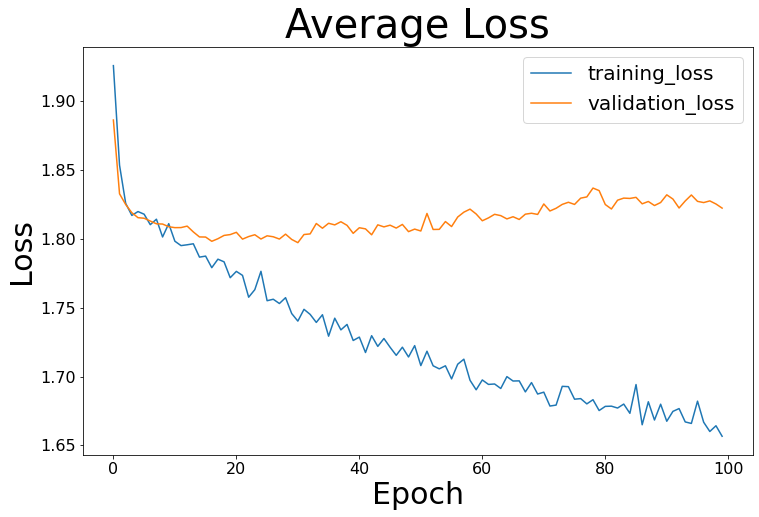

<Figure size 432x288 with 0 Axes>

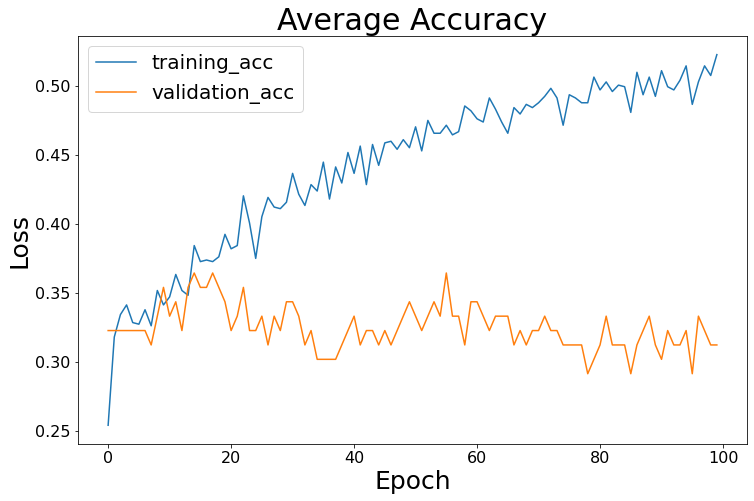

<Figure size 432x288 with 0 Axes>

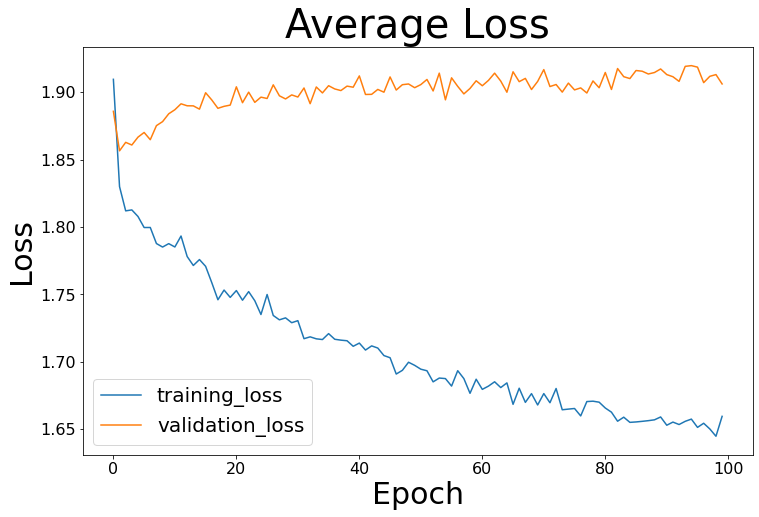

<Figure size 432x288 with 0 Axes>

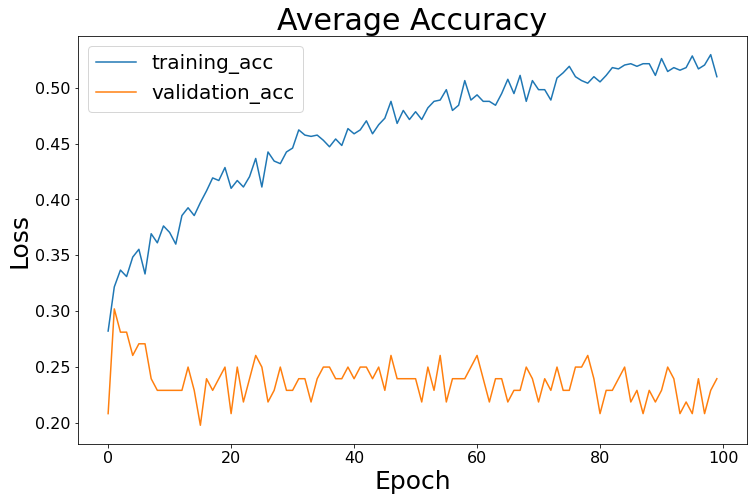

<Figure size 432x288 with 0 Axes>

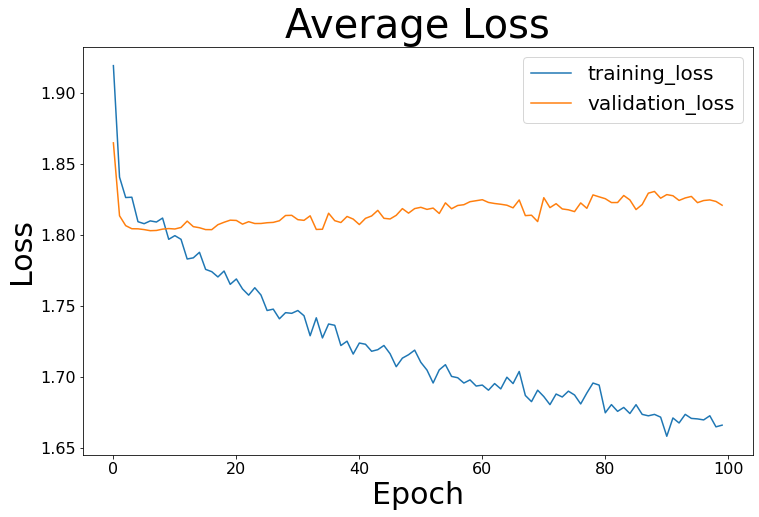

<Figure size 432x288 with 0 Axes>

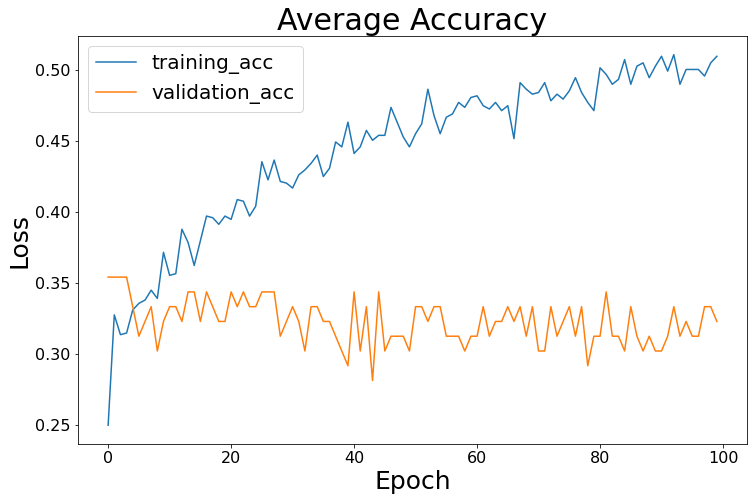

<Figure size 432x288 with 0 Axes>

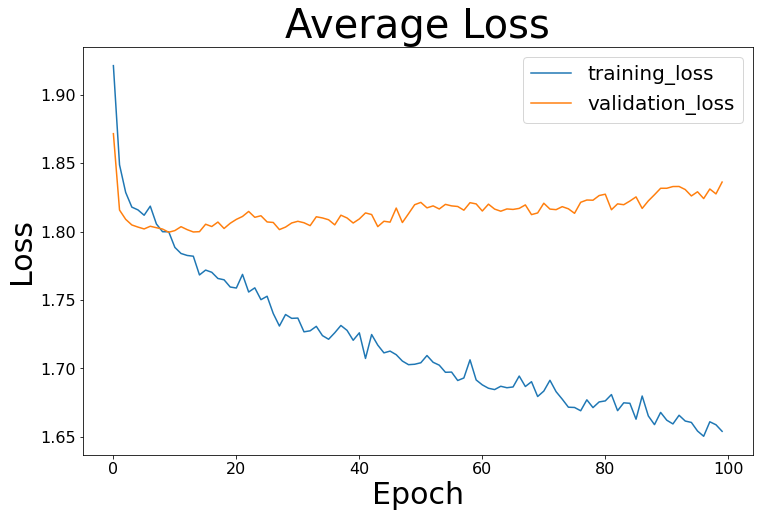

<Figure size 432x288 with 0 Axes>

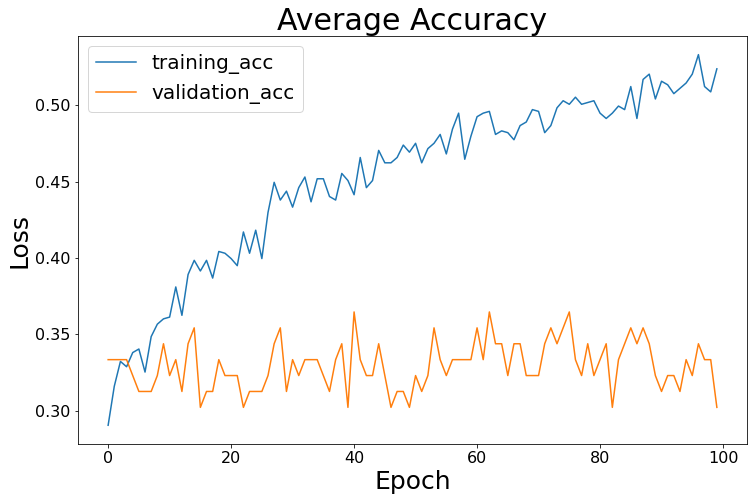

<Figure size 432x288 with 0 Axes>

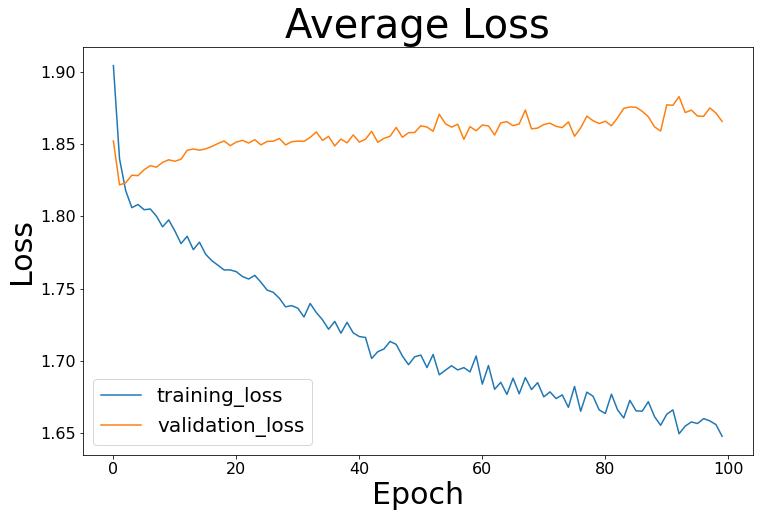

<Figure size 432x288 with 0 Axes>

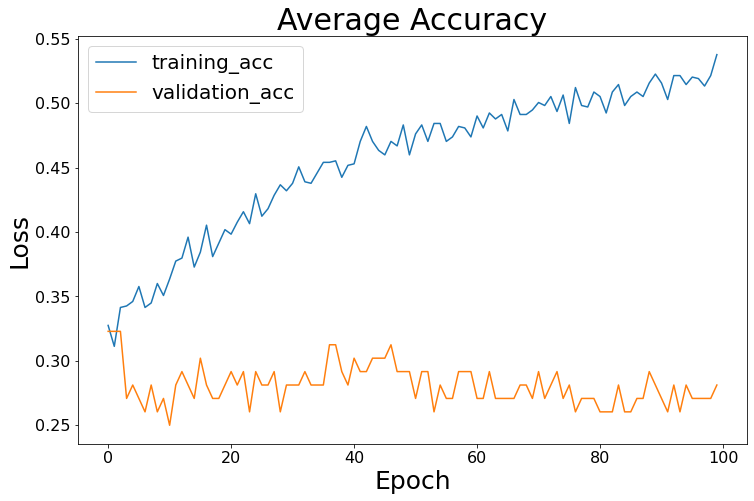

<Figure size 432x288 with 0 Axes>

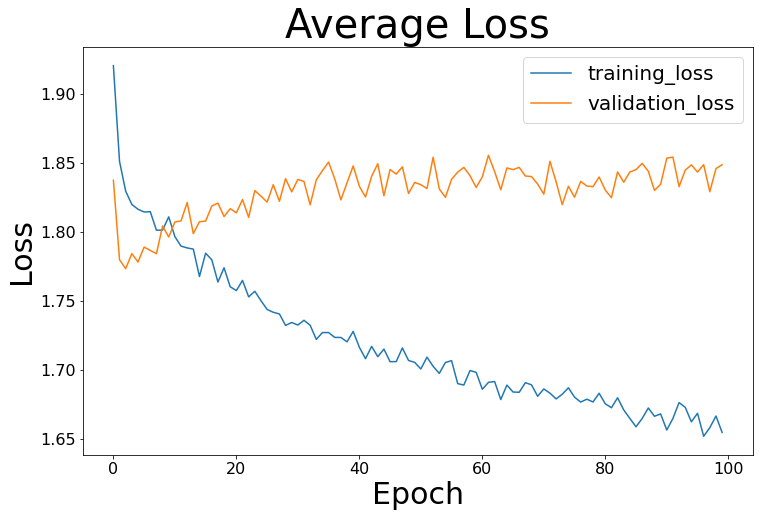

<Figure size 432x288 with 0 Axes>

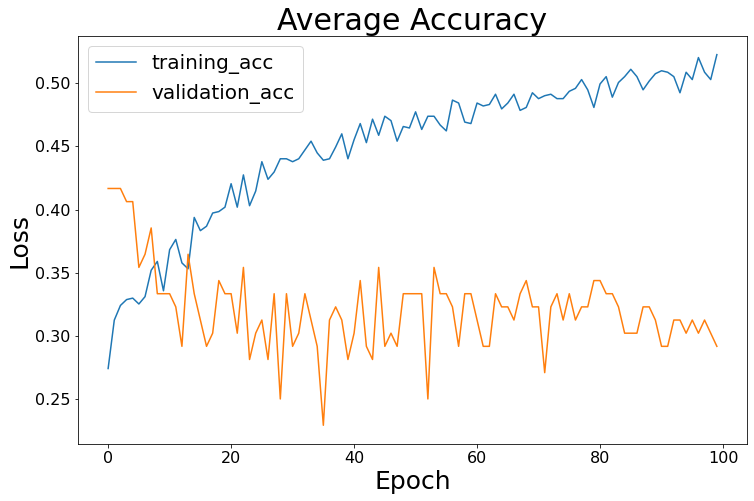

<Figure size 432x288 with 0 Axes>

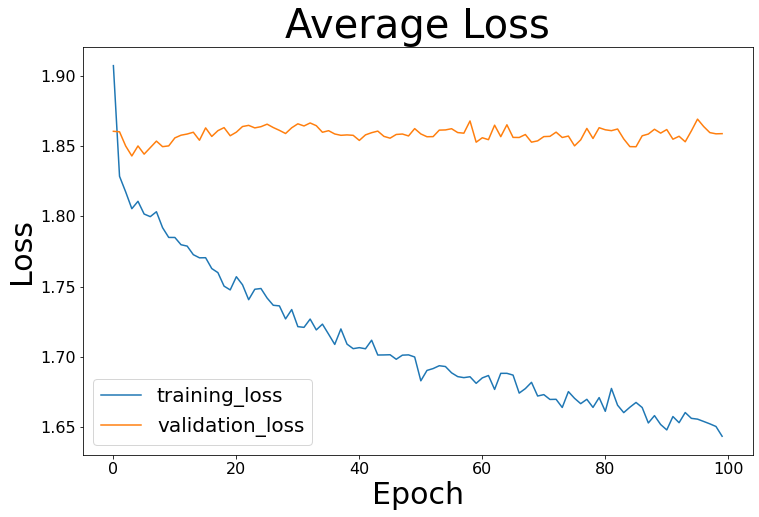

<Figure size 432x288 with 0 Axes>

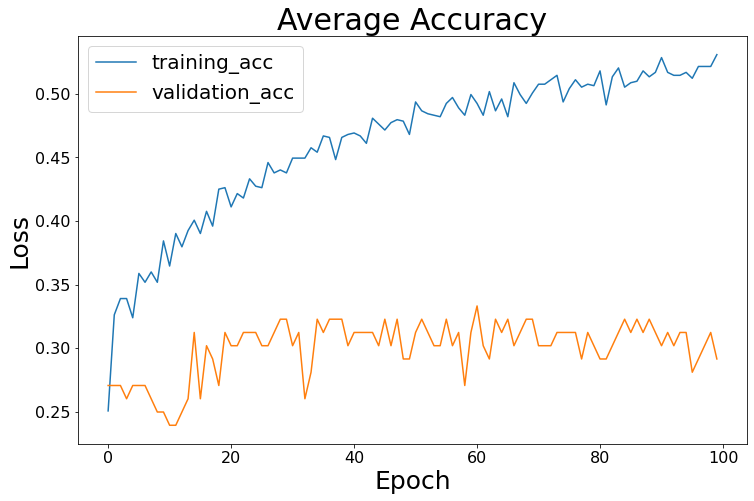

<Figure size 432x288 with 0 Axes>

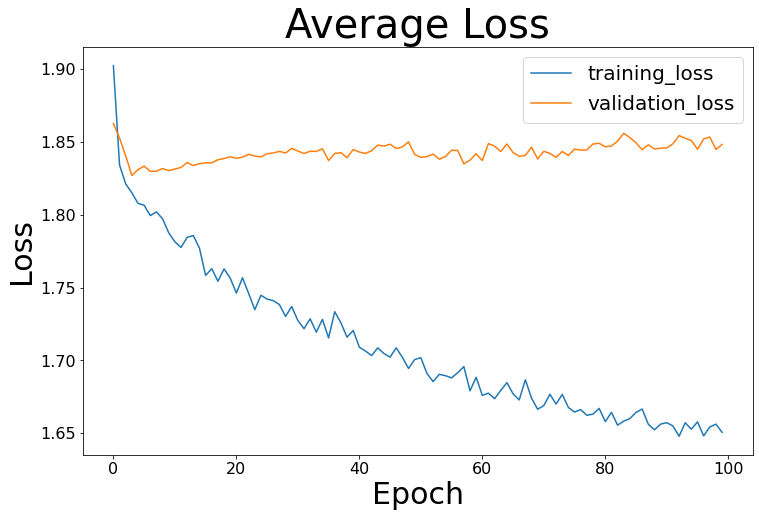

<Figure size 432x288 with 0 Axes>

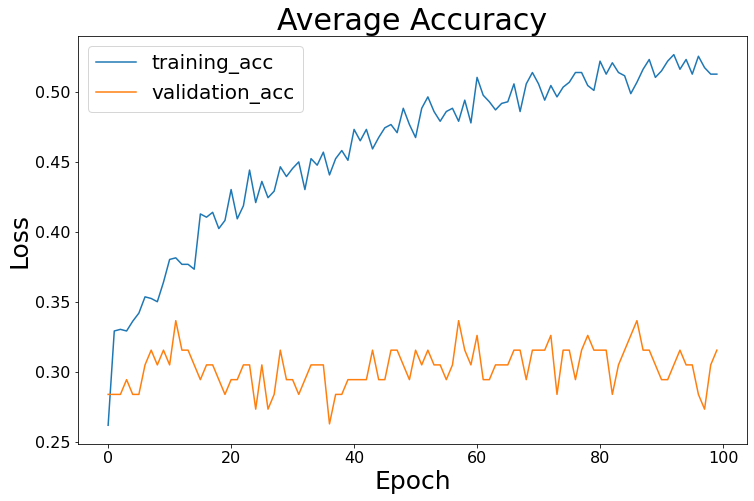

<Figure size 432x288 with 0 Axes>

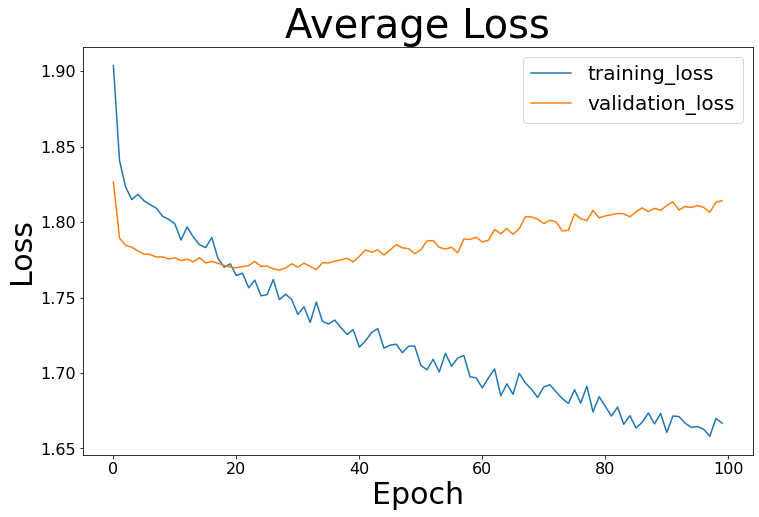

<Figure size 432x288 with 0 Axes>

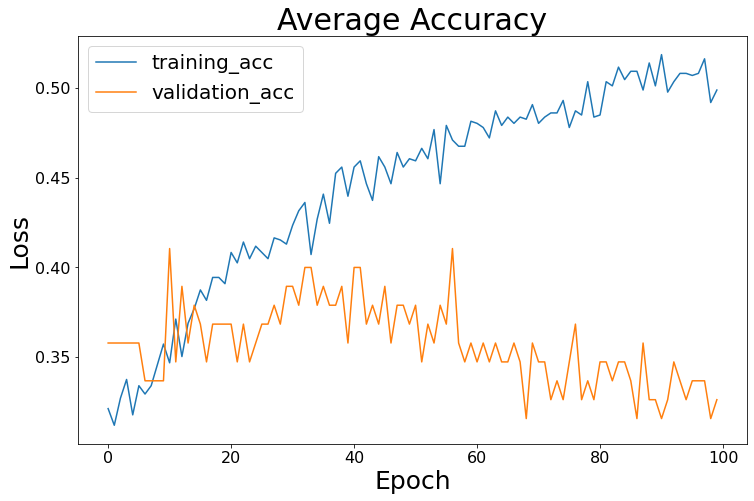

<Figure size 432x288 with 0 Axes>

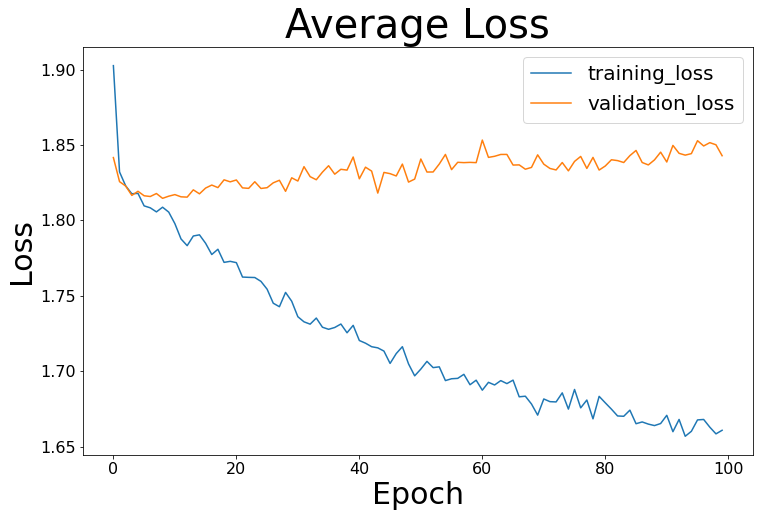

<Figure size 432x288 with 0 Axes>

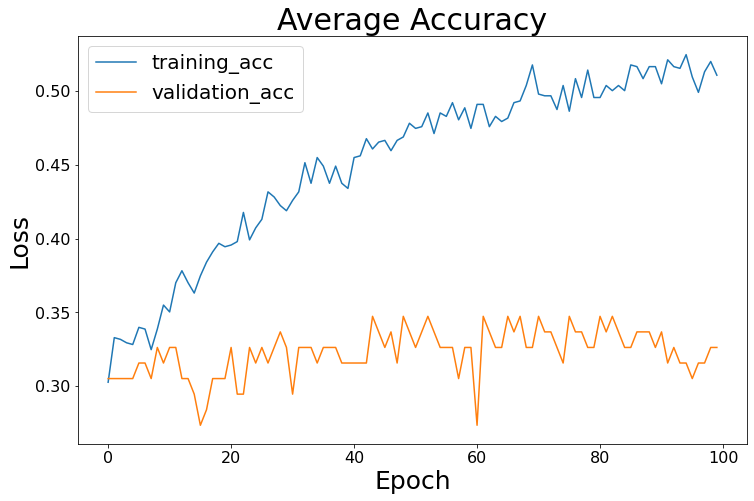

In [ ]:
MODEL_TYPE = "embedding-ns"
early_stop = False

confusion_matrix_list = []
losses_train = []
losses_valid = []
matthews = []
accuracies = []
accs_train = []
accs_valid = []

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(data)))):

    print(f'\n\n{20*"*"} Fold {fold + 1} {20*"*"}')

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    trainloader = DataLoader(data, batch_size=batch_size, sampler=train_sampler, num_workers=4)
    validloader = DataLoader(data, batch_size=batch_size, sampler=val_sampler, num_workers=4)

    model = ForthNeuralNetwork().to(device)
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Adam can be used as well #the step size can be changed and the loss value can be evaluated 
    optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4) # in order to prevent over-fitting
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    epochs = 100
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    confusion_matrix = torch.zeros(2, 3)
    confmat = ConfusionMatrix(task="multiclass", num_classes=7).to(device)
    f1_scores = MulticlassF1Score(num_classes=7).to(device)
    labels_list = []
    predictions_list = []
    for epoch in range(epochs):
        
        train_loss = 0.0
        model.train()
        i = 0
        batch_group = len(trainloader)
        train_total = 0
        train_correct = 0

        valid_total = 0
        valid_correct = 0
        valid_acc = []
        labels_list = []
        predictions_list = []

        print(f"\nTrain:")
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.float().to(device) #pytorch: batch, channel, height width --> we have 1D
            labels = (labels-1).to(device)
            labels_list.extend(labels)
            batch_len = labels.shape[0]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            #break
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predictions = torch.max(outputs.data, 1) #accuracy  
            predictions_list.extend(predictions)
            # Get training statistics.
            # print statistics
            train_loss += loss.item()
            if i % batch_group == batch_group-1: 
                #print(f"Train {i},({epoch}/{epochs}):\t{train_loss/i:.4f}") 
                #train_loss = 0.0
                i += 0
            i = i + 1
        
        train_losses.append(train_loss/batch_group)
        labels_list = [x.cpu() for x in labels_list]
        predictions_list = [x.cpu() for x in predictions_list]
        acc =  accuracy_score(labels_list, predictions_list)
        train_accs.append(acc)
        stats = 'Epoch [{}/{}], Step [{}], Loss: {:.4f}, Avg.Accuracy: {:.3f}'.format(epoch, epochs, i, np.mean(train_losses), acc)
        print(stats)

        #"""
        batch_group = len(validloader)
        valid_loss = 0.0
        labels_list = []
        predictions_list = []
        i = 0
        print(f"\nValidation:")
        model.eval()     # Optional when not using Model Specific layer
        for inputs, labels in validloader:

            inputs = inputs.float().to(device)
            labels = (labels-1).to(device)
            labels_list.extend(labels)

            batch_len = labels.shape[0]

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predictions = torch.max(outputs.data, 1)
            predictions_list.extend(predictions)

            # Calculate Loss
            valid_loss += loss.item()
            if i % batch_group == batch_group-1: 
                #print(f"Valid {i},({epoch}/{epochs}):\t{valid_loss/i:.4f}\n") 
                #valid_loss = 0.0
                i += 0
            i = i + 1
        valid_losses.append(valid_loss/batch_group)
        labels_list = torch.tensor([x.cpu() for x in labels_list])
        predictions_list = torch.tensor([x.cpu() for x in predictions_list])
        confusion_matrix = confmat(predictions_list.to(device), labels_list.to(device))
        acc =  accuracy_score(labels_list, predictions_list)
        valid_accs.append(acc)
        
        #"""
        if early_stop:
          early_stopping(np.mean(valid_losses), model)
          if early_stopping.early_stop:
              print("Early stopping")
              break
        #"""
        stats = 'Epoch [{}/{}], Step [{}], Loss: {:.4f}, Avg.Accuracy: {:.3f}'.format(epoch, epochs, i, np.mean(valid_losses), acc)
        print(stats)

        #"""
    confusion_matrix_list.append(confusion_matrix)

    print('Finished Training')
    filename = f"{MODEL_TYPE}-fnn-fold{fold}.model"
    torch.save(model.state_dict(), filename)
    print(f"Fold{fold}-Matthews: {matthews_corrcoef(labels_list, predictions_list)}")
    print(f"Fold{fold}-Accuracy: {accuracy_score(labels_list, predictions_list)}")
    plot_loss(train_losses,valid_losses,train_accs,valid_accs, fold, MODEL_TYPE)
    losses_train.append(train_losses)
    losses_valid.append(valid_losses)
    matthews.append(matthews_corrcoef(labels_list, predictions_list))
    accuracies.append(accuracy_score(labels_list, predictions_list))
    accs_train.append(train_accs)
    accs_valid.append(valid_accs)

backup_file = dict()
backup_file["losses_train"] = losses_train
backup_file["losses_valid"] = losses_valid
backup_file["matthews"] = matthews
backup_file["accuracies"] = accuracies
backup_file["accs_train"] = accs_train
backup_file["accs_valid"] = accs_valid
backup_file["confusion_matrix_list"] = [x.cpu().detach().tolist() for x in confusion_matrix_list]



with open(f"{MODEL_TYPE}-cnn-stats.json", "w") as file:
  json.dump(backup_file, file)

In [ ]:
"""
from matplotlib import pyplot as plt
import numpy as np

x = np.linspace(0, 30, 30)
y = np.array(train_losses)
error = np.random.normal(0.1, 0.02, size=y.shape)
y += np.random.normal(0, 0.1, size=y.shape)



mean = np.mean(train_losses)
std = np.std(train_losses)

z = std/np.sqrt(len(train_losses))
plt.figure(figsize=(10,10))
plt.plot(x, y, 'k-',figsize=(12,7.5))
plt.fill_between(x, y-z, y+z)
plt.show()
#"""

"\nfrom matplotlib import pyplot as plt\nimport numpy as np\n\nx = np.linspace(0, 30, 30)\ny = np.array(train_losses)\nerror = np.random.normal(0.1, 0.02, size=y.shape)\ny += np.random.normal(0, 0.1, size=y.shape)\n\n\n\nmean = np.mean(train_losses)\nstd = np.std(train_losses)\n\nz = std/np.sqrt(len(train_losses))\nplt.figure(figsize=(10,10))\nplt.plot(x, y, 'k-',figsize=(12,7.5))\nplt.fill_between(x, y-z, y+z)\nplt.show()\n#"

In [ ]:
accs_valid

[[0.3229166666666667,
  0.3229166666666667,
  0.3229166666666667,
  0.3229166666666667,
  0.3229166666666667,
  0.3229166666666667,
  0.3229166666666667,
  0.3125,
  0.3333333333333333,
  0.3541666666666667,
  0.3333333333333333,
  0.34375,
  0.3229166666666667,
  0.3541666666666667,
  0.3645833333333333,
  0.3541666666666667,
  0.3541666666666667,
  0.3645833333333333,
  0.3541666666666667,
  0.34375,
  0.3229166666666667,
  0.3333333333333333,
  0.3541666666666667,
  0.3229166666666667,
  0.3229166666666667,
  0.3333333333333333,
  0.3125,
  0.3333333333333333,
  0.3229166666666667,
  0.34375,
  0.34375,
  0.3333333333333333,
  0.3125,
  0.3229166666666667,
  0.3020833333333333,
  0.3020833333333333,
  0.3020833333333333,
  0.3020833333333333,
  0.3125,
  0.3229166666666667,
  0.3333333333333333,
  0.3125,
  0.3229166666666667,
  0.3229166666666667,
  0.3125,
  0.3229166666666667,
  0.3125,
  0.3229166666666667,
  0.3333333333333333,
  0.34375,
  0.3333333333333333,
  0.3229166666666

In [ ]:
accs_train

[[0.25435540069686413,
  0.31823461091753774,
  0.3344947735191638,
  0.34146341463414637,
  0.32868757259001163,
  0.32752613240418116,
  0.33797909407665505,
  0.32636469221835074,
  0.3519163763066202,
  0.34146341463414637,
  0.34727061556329847,
  0.3635307781649245,
  0.3519163763066202,
  0.34843205574912894,
  0.38443670150987225,
  0.37282229965156793,
  0.37398373983739835,
  0.37282229965156793,
  0.37630662020905925,
  0.39256678281068524,
  0.3821138211382114,
  0.38443670150987225,
  0.42044134727061555,
  0.40069686411149824,
  0.37514518002322883,
  0.40534262485482,
  0.41927990708478513,
  0.41231126596980255,
  0.41114982578397213,
  0.41579558652729387,
  0.4367015098722416,
  0.42160278745644597,
  0.413472706155633,
  0.42857142857142855,
  0.42392566782810687,
  0.4448315911730546,
  0.4181184668989547,
  0.4413472706155633,
  0.429732868757259,
  0.4518002322880372,
  0.4367015098722416,
  0.4564459930313589,
  0.42857142857142855,
  0.45760743321718933,
  0.442

In [ ]:
losses_train

[[1.9258432609063607,
  1.853508644633823,
  1.8258001804351807,
  1.817025935208356,
  1.8198383384280734,
  1.8179047063544944,
  1.8103050611637257,
  1.8142795651047319,
  1.8013791728902746,
  1.81105230472706,
  1.7982953875153154,
  1.7951019472546048,
  1.7957015346597742,
  1.7964252277656838,
  1.7867298700191356,
  1.7874687380260892,
  1.7790666509557653,
  1.7852421425007008,
  1.7833124708246302,
  1.771776799802427,
  1.7763808170954387,
  1.7734678939536765,
  1.7576222596345124,
  1.7631002223050152,
  1.7764374194321808,
  1.7550726157647591,
  1.756135927306281,
  1.7530326710806952,
  1.757280707359314,
  1.7457495795355902,
  1.7402652060544048,
  1.7488153245713975,
  1.7451358062249642,
  1.7393053461004186,
  1.744875426645632,
  1.729297646769771,
  1.742370777659946,
  1.7338874825724848,
  1.737837548609133,
  1.7261806108333446,
  1.7286329755076655,
  1.7174413910618536,
  1.7296533098927251,
  1.7218869659635756,
  1.727614508734809,
  1.7212633247728701,


In [ ]:
losses_valid

[[1.8863288164138794,
  1.8327409823735554,
  1.8249620199203491,
  1.8190197944641113,
  1.8153998851776123,
  1.8149780829747517,
  1.8129441340764363,
  1.810947299003601,
  1.8107632001241047,
  1.8088146448135376,
  1.808150331179301,
  1.808198054631551,
  1.8092581033706665,
  1.805045207341512,
  1.8013975222905476,
  1.8013181686401367,
  1.798234224319458,
  1.8000988960266113,
  1.8025049765904744,
  1.8031082550684612,
  1.8047561645507812,
  1.7998088200887044,
  1.8016809622446697,
  1.802997350692749,
  1.7999003728230794,
  1.802220622698466,
  1.8015214204788208,
  1.7998627821604412,
  1.8034324645996094,
  1.7995802561442058,
  1.7972491184870403,
  1.8031522830327351,
  1.8036013046900432,
  1.8111597299575806,
  1.8077339331309001,
  1.811320702234904,
  1.8101518551508586,
  1.8124455610911052,
  1.8098231951395671,
  1.8040248155593872,
  1.8080806732177734,
  1.8072664737701416,
  1.8029674688975017,
  1.8101913134257,
  1.808704137802124,
  1.8099355697631836,


In [ ]:
matthews

[0.018631616666032226,
 -0.05686640086417355,
 0.00994394364502686,
 -0.023540629710850882,
 -0.03420383697029859,
 -0.05402132795722868,
 0.004936318892418843,
 0.04523779475062247,
 0.0041542349966558435,
 0.034149701038914425]

In [ ]:
accuracies

[0.3125,
 0.23958333333333334,
 0.3229166666666667,
 0.3020833333333333,
 0.28125,
 0.2916666666666667,
 0.2916666666666667,
 0.3157894736842105,
 0.3263157894736842,
 0.3263157894736842]

In [ ]:
len(confusion_matrix_list)

10

In [ ]:
confusion_matrix_list

[tensor([[ 0, 10,  6,  0,  0,  0,  0],
         [ 0, 21, 10,  0,  0,  0,  0],
         [ 0, 16,  9,  0,  0,  0,  0],
         [ 0,  8,  2,  0,  0,  0,  0],
         [ 0,  4,  1,  0,  0,  0,  0],
         [ 0,  2,  2,  0,  0,  0,  0],
         [ 0,  2,  3,  0,  0,  0,  0]], device='cuda:0'),
 tensor([[ 0, 15,  7,  0,  0,  0,  0],
         [ 0, 18, 11,  0,  0,  0,  0],
         [ 0, 15,  5,  0,  0,  0,  0],
         [ 0,  8,  0,  0,  0,  0,  0],
         [ 0,  5,  4,  0,  0,  0,  0],
         [ 0,  4,  1,  0,  0,  0,  0],
         [ 0,  1,  2,  0,  0,  0,  0]], device='cuda:0'),
 tensor([[ 0, 13,  5,  0,  0,  0,  0],
         [ 0, 19, 15,  0,  0,  0,  0],
         [ 0, 14, 12,  0,  0,  0,  0],
         [ 0,  2,  5,  0,  0,  0,  0],
         [ 0,  2,  2,  0,  0,  0,  0],
         [ 0,  3,  3,  0,  0,  0,  0],
         [ 0,  0,  1,  0,  0,  0,  0]], device='cuda:0'),
 tensor([[ 0,  9,  2,  0,  0,  0,  0],
         [ 0, 17, 15,  0,  0,  0,  0],
         [ 0, 16, 12,  0,  0,  0,  0],
       

# TEST

### OHE

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

class MainclassTestDataset(Dataset):
    """Mainclass Dataset for Enzyme Sequences"""
    
    def __init__(self, data = pd.read_csv("testset.csv"), max_seqlen = 1000):
        
        def amino_acid_mapping(sequence:str):
            trans = str.maketrans("BUZJO", "XXXXX")
            sequence = sequence.translate(trans)
            map_aa = {
                'A': 0,
                'C': 1,
                'D': 2,
                'E': 3,
                'F': 4,
                'G': 5,
                'H': 6,
                'I': 7,
                'K': 8,
                'L': 9,
                'M': 10,
                'N': 11,
                'P': 12,
                'Q': 13,
                'R': 14,
                'S': 15,
                'T': 16,
                'V': 17,
                'W': 18,
                'Y': 19,
                'X': 20
            }
            if(len(sequence) <= max_seqlen):
                result = torch.zeros((max_seqlen, 21))
                for num_id, residue in enumerate(sequence):
                    result[num_id][map_aa[residue]] = 1
                return result
            return None
        
        
        self.data = data
        train_ohe = []
        for seq in self.data["Sequence"]:
            aa = amino_acid_mapping(seq)
            train_ohe.append(aa)
        self.data["One_Hot_Encoded_Sequences"] = train_ohe
        
        for row in self.data.index:
            if self.data.loc[row, 'One_Hot_Encoded_Sequences'] == None:
                self.data.drop(row, inplace = True)
        
    def __len__(self):
        return len(self.data["Enzyme_Mainclass"])

    def __getitem__(self, index):
        #print(index)
        #print(self.data.iloc[index, 1])
        return torch.tensor(self.data.iloc[index, 2]), torch.tensor(self.data.iloc[index, 1])
      
    def get_ohe(self):
        return self.data["One_Hot_Encoded_Sequences"]

In [ ]:
def plot_loss_test(valid_losses, valid_accs, fold, model_type):
  stat_dataframe = pd.DataFrame([])
  stat_dataframe["validation_loss"] = valid_losses
  stat_dataframe["validation_acc"] = valid_accs

  axes = [1,2]
  plt.figure()
  axes[0] = stat_dataframe[["validation_loss"]].plot(figsize=(12,7.5), title='Average Loss', fontsize=16)
  axes[0].title.set_size(40)
  axes[0].set_xlabel('Epoch',fontdict={'fontsize':30})
  axes[0].set_ylabel('Loss',fontdict={'fontsize':30})
  plt.legend(fontsize = 20)
  plt.savefig(f"{model_type}-loss-curve-fold{fold}.png")
  plt.figure()
  axes[1] = stat_dataframe[["validation_acc"]].plot(figsize=(12,7.5), title='Average Accuracy', fontsize=16)
  axes[1].title.set_size(30)
  axes[1].set_xlabel('Epoch',fontdict={'fontsize':25})
  axes[1].set_ylabel('Loss',fontdict={'fontsize':25})
  plt.legend(fontsize = 20)
  plt.savefig(f"{model_type}-accuracy-curve-fold{fold}.png")

In [ ]:
data = MainclassTestDataset()
torch.set_printoptions(edgeitems = 1000)

In [ ]:
testloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
MODEL_TYPE = "ohe-ns"

In [ ]:
confusion_matrix_list = []
losses_test = []
matthews = []
accuracies = []
accs_test = []

for i in range(0,10):
  model = ThirdNeuralNetwork().to(device)
  model.load_state_dict(torch.load(f"{MODEL_TYPE}-cnn-fold{i}.model"))
  model.eval()

  criterion = nn.CrossEntropyLoss()
  test_losses = []
  test_accs = []
  confusion_matrix = torch.zeros(7, 7)
  confmat = ConfusionMatrix(task="multiclass",num_classes=7).to(device)
  f1_scores = MulticlassF1Score(num_classes=7).to(device)
  labels_list = []
  predictions_list = []
  #"""
  batch_group = len(testloader)
  test_loss = 0.0
  labels_list = []
  predictions_list = []
  i = 0
  print(f"\nTesting:")
  model.eval()
  for inputs, labels in testloader:

      inputs = inputs.permute(0,2,1).to(device)
      labels = (labels-1).to(device)
      labels_list.extend(labels)

      batch_len = labels.shape[0]

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _, predictions = torch.max(outputs.data, 1)
      predictions_list.extend(predictions)
      
      temp = confmat(predictions, labels)
      if i==0:
          confusion_matrix = temp
      else:
          confusion_matrix += temp

      # Calculate Loss
      test_loss += loss.item()
      if i % batch_group == batch_group-1: 
          i += 0
      i = i + 1
  test_losses.append(test_loss/batch_group)
  labels_list = [x.cpu() for x in labels_list]
  predictions_list = [x.cpu() for x in predictions_list]
  acc =  accuracy_score(labels_list, predictions_list)
  test_accs.append(acc)

  stats = 'Step [{}], Loss: {:.4f}, Avg.Accuracy: {:.3f}'.format(i, np.mean(test_losses), acc)
  print(stats)

  confusion_matrix_list.append(confusion_matrix)
  losses_test.append(test_losses)
  matthews.append(matthews_corrcoef(labels_list, predictions_list))
  accuracies.append(accuracy_score(labels_list, predictions_list))
  accs_test.append(test_accs)

  #"""


Testing:
Step [3], Loss: 1.8758, Avg.Accuracy: 0.287

Testing:
Step [3], Loss: 1.8826, Avg.Accuracy: 0.250

Testing:
Step [3], Loss: 1.8856, Avg.Accuracy: 0.237

Testing:
Step [3], Loss: 1.9191, Avg.Accuracy: 0.200

Testing:
Step [3], Loss: 1.8323, Avg.Accuracy: 0.325

Testing:
Step [3], Loss: 1.8642, Avg.Accuracy: 0.325

Testing:
Step [3], Loss: 1.8389, Avg.Accuracy: 0.300

Testing:
Step [3], Loss: 1.7996, Avg.Accuracy: 0.375

Testing:
Step [3], Loss: 1.8311, Avg.Accuracy: 0.325

Testing:
Step [3], Loss: 1.7778, Avg.Accuracy: 0.350


In [ ]:
with open(f"{MODEL_TYPE}-cnn-stats.json", "r") as file:
  backup_file = json.load(file)

In [ ]:
backup_file["losses_test"] = losses_test
backup_file["matthews-test"] = matthews
backup_file["accuracies-test"] = accuracies
backup_file["accs_test"] = accs_test
backup_file["test-confusion_matrix_list"] = [x.cpu().detach().tolist() for x in confusion_matrix_list]


In [ ]:
with open(f"{MODEL_TYPE}-cnn-stats.json", "w") as file:
  json.dump(backup_file, file)

In [ ]:
np.mean(accs_test)

0.29750000000000004

###EMBEDDINGS TEST

In [ ]:
file_type = "test"
uid_to_ec_file = f"/content/drive/MyDrive/PBL/dataset/{file_type}_label.tsv"
embedding_file =f"/content/drive/MyDrive/PBL/PBL DATA/emb_pp_{file_type}_set.npz"
#emb_data = MainclassEmbeddingDataset(data_file=embedding_file, uid_to_ec_file=uid_to_ec_file)
#torch.set_printoptions(edgeitems = 1000)

In [ ]:
%%time
emb_data = MainclassEmbeddingPPDataset(data_file=embedding_file, uid_to_ec_file=uid_to_ec_file)

CPU times: user 21.5 ms, sys: 5.79 ms, total: 27.3 ms
Wall time: 863 ms


In [ ]:
testloader = torch.utils.data.DataLoader(emb_data, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
MODEL_TYPE = "embedding-ns"

In [ ]:
confusion_matrix_list = []
losses_test = []
matthews = []
accuracies = []
accs_test = []

for i in range(0,10):
  model = ForthNeuralNetwork().to(device)
  model.load_state_dict(torch.load(f"{MODEL_TYPE}-fnn-fold{i}.model"))
  model.eval()

  criterion = nn.CrossEntropyLoss()
  test_losses = []
  test_accs = []
  confusion_matrix = torch.zeros(7, 7)
  confmat = ConfusionMatrix(task="multiclass",num_classes=7).to(device)
  f1_scores = MulticlassF1Score(num_classes=7).to(device)
  labels_list = []
  predictions_list = []
  #"""
  batch_group = len(testloader)
  test_loss = 0.0
  labels_list = []
  predictions_list = []
  i = 0
  print(f"\nTesting:")
  model.eval()
  for inputs, labels in testloader:

      inputs = inputs.float().to(device)
      labels = (labels-1).to(device)
      labels_list.extend(labels)

      batch_len = labels.shape[0]

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _, predictions = torch.max(outputs.data, 1)
      predictions_list.extend(predictions)
      
      temp = confmat(predictions, labels)
      if i==0:
          confusion_matrix = temp
      else:
          confusion_matrix += temp

      # Calculate Loss
      test_loss += loss.item()
      if i % batch_group == batch_group-1: 
          i += 0
      i = i + 1
  test_losses.append(test_loss/batch_group)
  labels_list = [x.cpu() for x in labels_list]
  predictions_list = [x.cpu() for x in predictions_list]
  acc =  accuracy_score(labels_list, predictions_list)
  test_accs.append(acc)

  stats = 'Step [{}], Loss: {:.4f}, Avg.Accuracy: {:.3f}'.format(i, np.mean(test_losses), acc)
  print(stats)

  confusion_matrix_list.append(confusion_matrix)
  losses_test.append(test_losses)
  matthews.append(matthews_corrcoef(labels_list, predictions_list))
  accuracies.append(accuracy_score(labels_list, predictions_list))
  accs_test.append(test_accs)

  #"""


Testing:
Step [3], Loss: 1.8323, Avg.Accuracy: 0.325

Testing:
Step [3], Loss: 1.8560, Avg.Accuracy: 0.325

Testing:
Step [3], Loss: 1.8397, Avg.Accuracy: 0.350

Testing:
Step [3], Loss: 1.8043, Avg.Accuracy: 0.350

Testing:
Step [3], Loss: 1.8027, Avg.Accuracy: 0.338

Testing:
Step [3], Loss: 1.8423, Avg.Accuracy: 0.338

Testing:
Step [3], Loss: 1.8263, Avg.Accuracy: 0.325

Testing:
Step [3], Loss: 1.8170, Avg.Accuracy: 0.325

Testing:
Step [3], Loss: 1.8203, Avg.Accuracy: 0.338

Testing:
Step [3], Loss: 1.7922, Avg.Accuracy: 0.350


In [ ]:
with open(f"{MODEL_TYPE}-cnn-stats.json", "r") as file:
  backup_file = json.load(file)

In [ ]:
backup_file["losses_test"] = losses_test
backup_file["matthews-test"] = matthews
backup_file["accuracies-test"] = accuracies
backup_file["accs_test"] = accs_test
backup_file["test-confusion_matrix_list"] = [x.cpu().detach().tolist() for x in confusion_matrix_list]


In [ ]:
with open(f"{MODEL_TYPE}-cnn-stats.json", "w") as file:
  json.dump(backup_file, file)

In [ ]:
np.mean(accs_test)

0.33625000000000005

#EMBEDDING BASELINE MODEL 2 

In [ ]:
file_type = "test"
uid_to_ec_file = f"/content/drive/MyDrive/PBL/dataset/{file_type}_label.tsv"
embedding_file =f"/content/drive/MyDrive/PBL/PBL DATA/emb_pp_{file_type}_set.npz"
#emb_data = MainclassEmbeddingDataset(data_file=embedding_file, uid_to_ec_file=uid_to_ec_file)
#torch.set_printoptions(edgeitems = 1000)

In [ ]:
%%time
emb_data = MainclassEmbeddingPPDataset(data_file=embedding_file, uid_to_ec_file=uid_to_ec_file)

CPU times: user 28.7 ms, sys: 1.91 ms, total: 30.6 ms
Wall time: 1.89 s


In [ ]:
testloader = torch.utils.data.DataLoader(emb_data, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
MODEL_TYPE = "embedding-es"

In [ ]:
confusion_matrix_list = []
losses_test = []
matthews = []
accuracies = []
accs_test = []

for i in range(0,10):
  model = ForthNeuralNetwork().to(device)
  model.load_state_dict(torch.load(f"{MODEL_TYPE}-fnn-fold{i}.model"))
  model.eval()

  criterion = nn.CrossEntropyLoss()
  test_losses = []
  test_accs = []
  confusion_matrix = torch.zeros(7, 7)
  confmat = ConfusionMatrix(task="multiclass",num_classes=7).to(device)
  f1_scores = MulticlassF1Score(num_classes=7).to(device)
  labels_list = []
  predictions_list = []
  #"""
  batch_group = len(testloader)
  test_loss = 0.0
  labels_list = []
  predictions_list = []
  i = 0
  print(f"\nTesting:")
  model.eval()
  for _, labels in testloader:

      inputs = torch.rand(labels.shape[0], 1024).to(device)
      labels = (labels-1).to(device)
      labels_list.extend(labels)

      batch_len = labels.shape[0]

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _, predictions = torch.max(outputs.data, 1)
      predictions_list.extend(predictions)
      
      temp = confmat(predictions, labels)
      if i==0:
          confusion_matrix = temp
      else:
          confusion_matrix += temp

      # Calculate Loss
      test_loss += loss.item()
      if i % batch_group == batch_group-1: 
          i += 0
      i = i + 1
  test_losses.append(test_loss/batch_group)
  labels_list = [x.cpu() for x in labels_list]
  predictions_list = [x.cpu() for x in predictions_list]
  acc =  accuracy_score(labels_list, predictions_list)
  test_accs.append(acc)

  stats = 'Step [{}], Loss: {:.4f}, Avg.Accuracy: {:.3f}'.format(i, np.mean(test_losses), acc)
  print(stats)

  confusion_matrix_list.append(confusion_matrix)
  losses_test.append(test_losses)
  matthews.append(matthews_corrcoef(labels_list, predictions_list))
  accuracies.append(accuracy_score(labels_list, predictions_list))
  accs_test.append(test_accs)

  #"""


Testing:
Step [3], Loss: 1.8124, Avg.Accuracy: 0.350

Testing:
Step [3], Loss: 1.9018, Avg.Accuracy: 0.287

Testing:
Step [3], Loss: 1.8661, Avg.Accuracy: 0.275

Testing:
Step [3], Loss: 1.8741, Avg.Accuracy: 0.275

Testing:
Step [3], Loss: 1.8572, Avg.Accuracy: 0.300

Testing:
Step [3], Loss: 1.8666, Avg.Accuracy: 0.362

Testing:
Step [3], Loss: 1.8659, Avg.Accuracy: 0.300

Testing:
Step [3], Loss: 1.8897, Avg.Accuracy: 0.275

Testing:
Step [3], Loss: 1.8912, Avg.Accuracy: 0.263

Testing:
Step [3], Loss: 1.8507, Avg.Accuracy: 0.338


In [ ]:
np.mean(accuracies), np.mean(matthews)


(0.3025, -0.003844962069393689)

In [ ]:
def std_error(data):
  mean = np.mean(data)
  std = np.std(data)
  return f"{mean:.3f} +/- {std/np.sqrt(len(data)):.3f}" 

In [ ]:
std_error(accuracies), std_error(matthews)


('0.302 +/- 0.011', '-0.004 +/- 0.023')

In [ ]:
torch.stack(confusion_matrix_list).float().mean(dim=0)

tensor([[ 0.0000,  8.4000,  4.6000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 15.6000, 10.4000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 13.4000,  8.6000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  5.2000,  2.8000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  3.3000,  1.7000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.8000,  1.2000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

# baseline ohee

### OHE

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

class MainclassTestDataset(Dataset):
    """Mainclass Dataset for Enzyme Sequences"""
    
    def __init__(self, data = pd.read_csv("testset.csv"), max_seqlen = 1000):
        
        def amino_acid_mapping(sequence:str):
            trans = str.maketrans("BUZJO", "XXXXX")
            sequence = sequence.translate(trans)
            map_aa = {
                'A': 0,
                'C': 1,
                'D': 2,
                'E': 3,
                'F': 4,
                'G': 5,
                'H': 6,
                'I': 7,
                'K': 8,
                'L': 9,
                'M': 10,
                'N': 11,
                'P': 12,
                'Q': 13,
                'R': 14,
                'S': 15,
                'T': 16,
                'V': 17,
                'W': 18,
                'Y': 19,
                'X': 20
            }
            if(len(sequence) <= max_seqlen):
                result = torch.zeros((max_seqlen, 21))
                for num_id, residue in enumerate(sequence):
                    result[num_id][map_aa[residue]] = 1
                return result
            return None
        
        
        self.data = data
        train_ohe = []
        for seq in self.data["Sequence"]:
            aa = amino_acid_mapping(seq)
            train_ohe.append(aa)
        self.data["One_Hot_Encoded_Sequences"] = train_ohe
        
        for row in self.data.index:
            if self.data.loc[row, 'One_Hot_Encoded_Sequences'] == None:
                self.data.drop(row, inplace = True)
        
    def __len__(self):
        return len(self.data["Enzyme_Mainclass"])

    def __getitem__(self, index):
        #print(index)
        #print(self.data.iloc[index, 1])
        return torch.tensor(self.data.iloc[index, 2]), torch.tensor(self.data.iloc[index, 1])
      
    def get_ohe(self):
        return self.data["One_Hot_Encoded_Sequences"]

In [ ]:
data = MainclassTestDataset()
torch.set_printoptions(edgeitems = 1000)

In [ ]:
testloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
MODEL_TYPE = "ohe-ns"

In [ ]:
for x,y in testloader:
  break

In [ ]:
x.shape

torch.Size([32, 1000, 21])

In [ ]:
confusion_matrix_list = []
losses_test = []
matthews = []
accuracies = []
accs_test = []

for i in range(0,10):
  model = ThirdNeuralNetwork().to(device)
  model.load_state_dict(torch.load(f"{MODEL_TYPE}-cnn-fold{i}.model"))
  model.eval()

  criterion = nn.CrossEntropyLoss()
  test_losses = []
  test_accs = []
  confusion_matrix = torch.zeros(7, 7)
  confmat = ConfusionMatrix(task="multiclass",num_classes=7).to(device)
  f1_scores = MulticlassF1Score(num_classes=7).to(device)
  labels_list = []
  predictions_list = []
  #"""
  batch_group = len(testloader)
  test_loss = 0.0
  labels_list = []
  predictions_list = []
  i = 0
  print(f"\nTesting:")
  model.eval()
  for inputs, labels in testloader:

      inputs = inputs.rand(([32, 1000, 21])).to(device)
      labels = (labels-1).to(device)
      labels_list.extend(labels)

      batch_len = labels.shape[0]

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _, predictions = torch.max(outputs.data, 1)
      predictions_list.extend(predictions)
      
      temp = confmat(predictions, labels)
      if i==0:
          confusion_matrix = temp
      else:
          confusion_matrix += temp

      # Calculate Loss
      test_loss += loss.item()
      if i % batch_group == batch_group-1: 
          i += 0
      i = i + 1
  test_losses.append(test_loss/batch_group)
  labels_list = [x.cpu() for x in labels_list]
  predictions_list = [x.cpu() for x in predictions_list]
  acc =  accuracy_score(labels_list, predictions_list)
  test_accs.append(acc)

  stats = 'Step [{}], Loss: {:.4f}, Avg.Accuracy: {:.3f}'.format(i, np.mean(test_losses), acc)
  print(stats)

  confusion_matrix_list.append(confusion_matrix)
  losses_test.append(test_losses)
  matthews.append(matthews_corrcoef(labels_list, predictions_list))
  accuracies.append(accuracy_score(labels_list, predictions_list))
  accs_test.append(test_accs)

  #"""


Testing:
Step [3], Loss: 1.8758, Avg.Accuracy: 0.287

Testing:
Step [3], Loss: 1.8826, Avg.Accuracy: 0.250

Testing:
Step [3], Loss: 1.8856, Avg.Accuracy: 0.237

Testing:
Step [3], Loss: 1.9191, Avg.Accuracy: 0.200

Testing:
Step [3], Loss: 1.8323, Avg.Accuracy: 0.325

Testing:
Step [3], Loss: 1.8642, Avg.Accuracy: 0.325

Testing:
Step [3], Loss: 1.8389, Avg.Accuracy: 0.300

Testing:
Step [3], Loss: 1.7996, Avg.Accuracy: 0.375

Testing:
Step [3], Loss: 1.8311, Avg.Accuracy: 0.325

Testing:
Step [3], Loss: 1.7778, Avg.Accuracy: 0.350


In [ ]:
with open(f"{MODEL_TYPE}-cnn-stats.json", "r") as file:
  backup_file = json.load(file)

In [ ]:
backup_file["losses_test"] = losses_test
backup_file["matthews-test"] = matthews
backup_file["accuracies-test"] = accuracies
backup_file["accs_test"] = accs_test
backup_file["test-confusion_matrix_list"] = [x.cpu().detach().tolist() for x in confusion_matrix_list]


In [ ]:
with open(f"{MODEL_TYPE}-cnn-stats.json", "w") as file:
  json.dump(backup_file, file)

In [ ]:
np.mean(accs_test)

0.29750000000000004

# Plottings

In [ ]:
#MODEL_TYPE = "embedding-es"
#MODEL_TYPE = "embedding-ns"
#MODEL_TYPE = "ohe-es"
MODEL_TYPE = "ohe-ns"

In [ ]:
with open(f"{MODEL_TYPE}-cnn-stats.json", "r") as file:
  backup_file = json.load(file)

In [ ]:
backup_file.keys()

dict_keys(['losses_train', 'losses_valid', 'matthews', 'accuracies', 'accs_train', 'accs_valid', 'confusion_matrix_list', 'losses_test', 'matthews-test', 'accuracies-test', 'accs_test', 'test-confusion_matrix_list'])

In [ ]:
losses_train = backup_file["losses_train"]
losses_valid = backup_file["losses_valid"]
losses_test = backup_file["losses_test"]

accs_train = backup_file["accs_train"]
accs_valid = backup_file["accs_valid"]
accs_test = backup_file["accs_test"]

confusion_matrix_list = backup_file["confusion_matrix_list"]
test_confusion_matrix_list = backup_file["test-confusion_matrix_list"]

matthews = backup_file["matthews"]
matthews_test = backup_file["matthews-test"]

accuracies = backup_file["accuracies"]
accuracies_test = backup_file["accuracies-test"]

Text(0.5, 1.0, 'CNN - Accuracy over Epochs (Without Early Stoppig)')

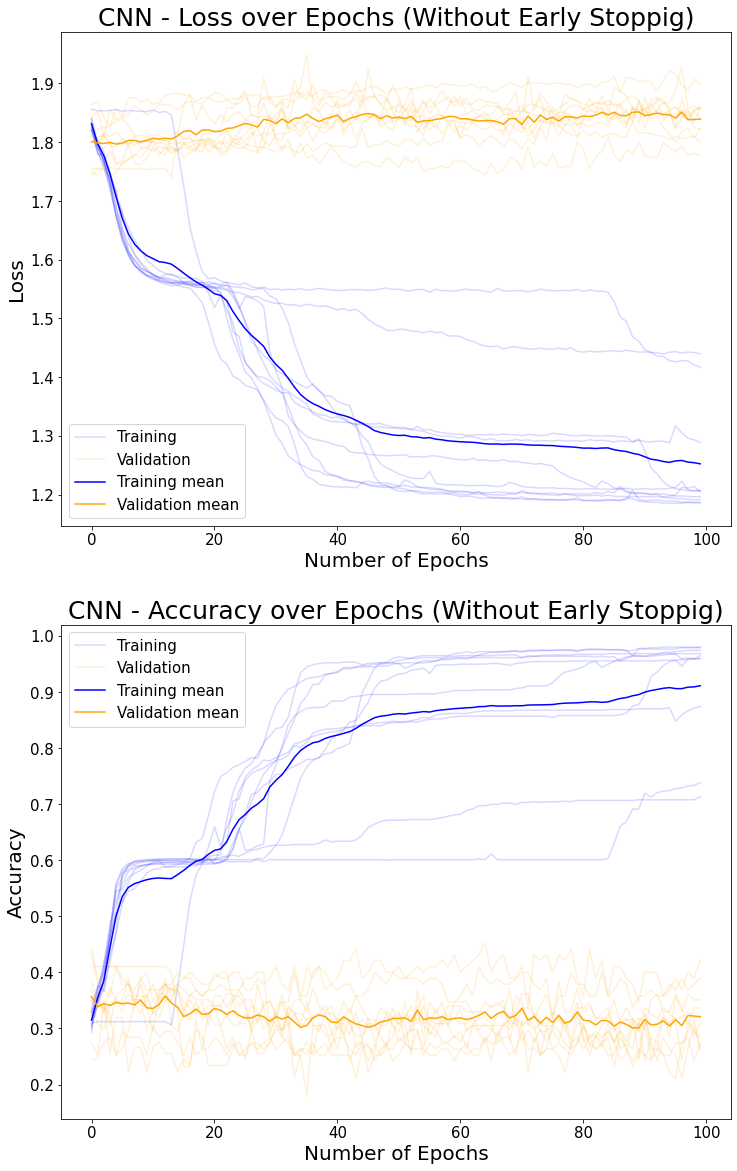

In [ ]:
fig, axs = plt.subplots(2, figsize=(12,20))
for i, (train, valid) in enumerate(zip(losses_train, losses_valid)):

  axs[0].plot(train, "b", alpha=0.15, label='Training' if i == 0 else '')
  axs[0].plot(valid, "orange", alpha=0.15, label='Validation' if i == 0 else '')


axs[0].plot(pd.DataFrame(losses_train).mean(axis=0).values, 'b', label='Training mean')
axs[0].plot(pd.DataFrame(losses_valid).mean(axis=0).values, 'orange', label='Validation mean')
axs[0].legend(fontsize=15)

axs[0].set_xlabel('Number of Epochs', fontsize=20)
axs[0].set_ylabel('Loss', fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].set_title("CNN - Loss over Epochs (Without Early Stoppig)", fontsize=25)

for i, (train, valid) in enumerate(zip(accs_train, accs_valid)):

  axs[1].plot(train, "b", alpha=0.15, label='Training' if i == 0 else '')
  axs[1].plot(valid, "orange", alpha=0.15, label='Validation' if i == 0 else '')


axs[1].plot(pd.DataFrame(accs_train).mean(axis=0).values, 'b', label='Training mean')
axs[1].plot(pd.DataFrame(accs_valid).mean(axis=0).values, 'orange', label='Validation mean')
axs[1].legend(fontsize=15)

axs[1].set_xlabel('Number of Epochs', fontsize=20)
axs[1].set_ylabel('Accuracy', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=15)
axs[1].set_title("CNN - Accuracy over Epochs (Without Early Stoppig)", fontsize=25)


In [ ]:
np.stack(confusion_matrix_list).mean(axis=0)

array([[ 3.1,  5.5,  4.6,  1. ,  0.7,  0.2,  0.1],
       [ 3.5, 15.3,  9. ,  1.7,  0.7,  0.2,  0.1],
       [ 2.4,  9.8, 11. ,  1.3,  1. ,  0.4,  0.1],
       [ 1.1,  4.2,  4.3,  0.4,  0.2,  0.1,  0. ],
       [ 0.7,  1.9,  2.3,  0.5,  0.4,  0.1,  0. ],
       [ 0.1,  1.3,  1.6,  0.1,  0. ,  0.1,  0. ],
       [ 0.4,  1.5,  1.3,  0.2,  0.1,  0. ,  0.1]])

In [ ]:
np.stack(test_confusion_matrix_list).mean(axis=0)

array([[ 1.9,  5.5,  3.4,  1.2,  1. ,  0. ,  0. ],
       [ 3. , 13.2,  7.5,  2.1,  0.2,  0. ,  0. ],
       [ 3.8,  8.5,  8.2,  1. ,  0.4,  0. ,  0.1],
       [ 1.2,  4.4,  2. ,  0.3,  0.1,  0. ,  0. ],
       [ 0.8,  1.4,  2.5,  0.1,  0.2,  0. ,  0. ],
       [ 0.5,  1.8,  0.3,  0.2,  0.2,  0. ,  0. ],
       [ 1. ,  1.2,  0.4,  0.3,  0.1,  0. ,  0. ]])

In [ ]:
def std_error(data):
  mean = np.mean(data)
  std = np.std(data)
  return f"{mean:.3f} +/- {std/np.sqrt(len(data)):.3f}" 

"""
For plus minus inn latex use \pm
"""

'\nFor plus minus inn latex use \\pm\n'

In [ ]:
accuracies_test

[0.2875, 0.25, 0.2375, 0.2, 0.325, 0.325, 0.3, 0.375, 0.325, 0.35]

In [ ]:
std_error(accuracies_test)

'0.298 +/- 0.016'

In [ ]:
std_error(accuracies)

'0.321 +/- 0.016'

In [ ]:
std_error(matthews_test)

'0.048 +/- 0.024'

In [ ]:
std_error(matthews)

'0.090 +/- 0.023'